In [153]:
import os
from tempfile import tempdir
from time import time
from turtle import color
from unittest.mock import NonCallableMagicMock
import pandas as pd
import numpy as np
import warnings
import math
import re

import seaborn as sns
warnings.filterwarnings("ignore")

import sys
sys.path.append("./")

from pathlib import Path

import tqdm
import importlib

import matplotlib.pyplot as plt
# from PySide2.QtWidgets import QFileDialog, QApplication
# from PySide2.QtCore import Qt
from copy import copy 

from corems.mass_spectra.input import rawFileReader
from corems.molecular_id.factory.classification import HeteroatomsClassification, Labels
from corems.molecular_id.search.priorityAssignment import OxygenPriorityAssignment
from corems.molecular_id.search.molecularFormulaSearch import SearchMolecularFormulas
from corems.encapsulation.factory.parameters import MSParameters
from corems.encapsulation.constant import Atoms
from corems.mass_spectrum.calc.Calibration import MzDomainCalibration

import importlib

import corems.lc_icpms_ftms.calc.lc_icrms_qc_assign as icrms

importlib.reload(icrms)



<module 'corems.lc_icpms_ftms.calc.lc_icrms_qc_assign' from '/Users/christiandewey/CoreMS/corems/lc_icpms_ftms/calc/lc_icrms_qc_assign.py'>

In [154]:
def getParser(file):
    parser = rawFileReader.ImportMassSpectraThermoMSFileReader(file)
    return parser

def assign_formula(parser, interval, timerange, refmasslist=None):
    #Function to build formula assignment lists
    #Retrieve TIC for MS1 scans over the time range between 'timestart' and 'timestop' 

    tic=parser.get_tic(ms_type='MS')[0]
    tic_df=pd.DataFrame({'time': tic.time,'scan': tic.scans})

    times=list(range(timerange[0],timerange[1],interval))

    results=[]
    
    for timestart in times:

        scans=tic_df[tic_df.time.between(timestart,timestart+interval)].scan.tolist()

        mass_spectrum = parser.get_average_mass_spectrum_by_scanlist(scans)    
        mass_spectrum.molecular_search_settings.ion_charge = 1

        #mass_spectrum.mass_spectrum.settings.calib_sn_threshold
        #mass_spectrum.mass_spectrum.settings.calib_pol_order
        #mass_spectrum.recalibrate_mass_spectrum(mass_spectrum, imzmeas, mzrefs, order=2)
        #MzDomainCalibration(mass_spectrum, ref_file_location).run()

        if refmasslist:
            mass_spectrum.settings.min_calib_ppm_error = 10
            mass_spectrum.settings.max_calib_ppm_error = -10
            calfn = MzDomainCalibration(mass_spectrum, refmasslist)
            ref_mass_list_fmt = calfn.load_ref_mass_list(refmasslist)

            imzmeas, mzrefs = calfn.find_calibration_points(mass_spectrum, ref_mass_list_fmt,
                                                        calib_ppm_error_threshold=(0, 2.0),
                                                        calib_snr_threshold=3)

            calfn.recalibrate_mass_spectrum(mass_spectrum, imzmeas, mzrefs, order=2)


        SearchMolecularFormulas(mass_spectrum, first_hit=False).run_worker_mass_spectrum()

        mass_spectrum.percentile_assigned(report_error=True)

        assignments=mass_spectrum.to_dataframe()

        assignments['Time']=timestart

        results.append(assignments)
    
    results=pd.concat(results,ignore_index=True)

    return(results)    


In [155]:
def plot_ms(df1, start_mz, end_mz, tstart=None, df2=None,df3=None, assignment= None, ax_ms=None, lbls=None, norm=False, labs=False, colors=None):   
    
    if ax_ms == None:
        _, ax = plt.subplots()
    
    else:
        ax = ax_ms

    if colors is not None:
        cols = colors
    else:
        cols = ['C0', 'C1', 'C2']
    mzrange= end_mz - start_mz

    if tstart != None:
        ms_t_int=df1[df1['Time'] == tstart]
    else:
        ms_t_int=df1

    ms_df = ms_t_int[((ms_t_int['Calibrated m/z']-start_mz)<mzrange) & ((ms_t_int['Calibrated m/z']-start_mz)>0)]


    if norm:

        pltcol = 'Normalized Peak Height'

    else:
        pltcol = 'S/N'

    
    if lbls is not None:
        labels = lbls
    else:
        labels = [None, None, None]

 
    _, stemlines1, _ =ax.stem('Calibrated m/z',pltcol,data=ms_df,  markerfmt=' ', basefmt=' ', linefmt=cols[0], label = labels[0])
    
    if (df2 is not None) and (len(df2['Molecular Formula'])>0):
        pltdf2 = True
        if tstart != None:
            ms_t_int2=df2[df2['Time'] == tstart]
        else:
            ms_t_int2=df2

        ms_df2 = ms_t_int2[(abs(ms_t_int2['Calibrated m/z']-start_mz)<mzrange)& ((ms_t_int2['Calibrated m/z']-start_mz)>0)]
        
        _, stemlines2, _ =ax.stem('Calibrated m/z',pltcol,data=ms_df2,  markerfmt=' ', basefmt=' ', linefmt=cols[1], label = labels[1])
    else:
        pltdf2 = False 

    if (df3 is not None) and (len(df3['Molecular Formula'])>0):
        pltdf3 = True
        if tstart != None:
            ms_t_int3=df3[df3['Time'] == tstart]
        else:
            ms_t_int3=df3

        ms_df3 = ms_t_int3[(abs(ms_t_int3['Calibrated m/z']-start_mz)<mzrange)& ((ms_t_int3['Calibrated m/z']-start_mz)>0)]

        
        _, stemlines3, _ =ax.stem('Calibrated m/z',pltcol,data=ms_df3,  markerfmt=' ', basefmt=' ', linefmt=cols[2], label = labels[2])
    else:
        pltdf3 = False
    #if pltdf3 is True:
    #    ax.set_ylim(0, max([maxdf1, maxdf2, maxdf3]) * 1.1)
    #elif pltdf2 is True:
    #    ax.set_ylim(0, max([maxdf1, maxdf2]) * 1.1)
    #else: 
    #    ax.set_ylim(0, maxdf1 * 1.1)

    ax.set_xlim(left = start_mz - mzrange*0.1, right = start_mz + mzrange + mzrange*0.1) 

    if labs:
        for mzr,peakr,mf,er in zip(ms_df['Calibrated m/z'], ms_df[pltcol], ms_df['Molecular Formula'],  ms_df['m/z Error (ppm)']):

            #if (mzr- target_mz)  == 0:
            #    mz_text = ' m/z\n%.4f' % (mzr)
            #else:
            #    mz_text = r'$\Delta$' + ' m/z\n%.4f' % (mzr- target_mz)

            mz_text = 'm/z %.4f\n%s\n%.3f ppm' % (mzr,mf,er)
            ax.text(mzr, peakr + 0.02 *max(ms_df[pltcol]), mz_text, ha = 'center', fontsize = 'xx-small', weight = 'bold', color=cols[0])

        if df2 is not None:

            for mzr,peakr,mf, er in zip(ms_df2['Calibrated m/z'], ms_df2[pltcol], ms_df2['Molecular Formula'], ms_df2['m/z Error (ppm)']):

            #if (mzr- target_mz)  == 0:
            #    mz_text = ' m/z\n%.4f' % (mzr)
            #else:
            #    mz_text = r'$\Delta$' + ' m/z\n%.4f' % (mzr- target_mz)

                mz_text = 'm/z %.4f\n%s\n%.3f ppm' % (mzr,mf,er)
                ax.text(mzr, peakr + 0.02 *max(ms_df2[pltcol]), mz_text, ha = 'center', fontsize = 'xx-small', weight = 'bold', color = cols[1])

        if df3 is not None:

            for mzr,peakr,mf, er in zip(ms_df3['Calibrated m/z'], ms_df3[pltcol], ms_df3['Molecular Formula'], ms_df3['m/z Error (ppm)']):

            #if (mzr- target_mz)  == 0:
            #    mz_text = ' m/z\n%.4f' % (mzr)
            #else:
            #    mz_text = r'$\Delta$' + ' m/z\n%.4f' % (mzr- target_mz)

                mz_text = 'm/z %.4f\n%s\n%.3f ppm' % (mzr,mf,er)
                ax.text(mzr, peakr + 0.02 *max(ms_df3[pltcol]), mz_text, ha = 'center', fontsize = 'xx-small', weight = 'bold', color = cols[2])

   # theor_mz=pattern.mdiff+result['mass']
   # theor_int=pattern.ratio*result['abundance']
   # ax.stem(theor_mz,theor_int, basefmt=' ',linefmt='gray')

   # for isotope in pattern.isotope[pattern.requirement=='Y']:
   #     ax.stem('mz','intense',data=result[isotope],  markerfmt=' ', basefmt=' ',linefmt='red')
    ax.set_xlim(start_mz, end_mz)
    
    if ax == None:

        ax.legend(('other', 'target'),bbox_to_anchor=(1.05, 1.0), loc='upper left',frameon=False)

        if(assignment):

            mf = assignment[0]
            score = assignment[1]
            er = assignment[2]

            ax.text(1.05,0.7,mf,transform=ax.transAxes)
            ax.text(1.05,0.6,'Error (ppm) = %.3f ' %er ,transform=ax.transAxes)
            ax.text(1.05,0.5,'Score = %.3f' %score ,transform=ax.transAxes)

    if norm: 
        ax.set(xlabel='Calibrated m/z',ylabel='Normalized Intensity')
    else: 
        ax.set(xlabel='Calibrated m/z',ylabel='Intensity')
    #ax.set_title('%.2f' %timerange[0] + ' to %.2f' %timerange[1] +' min', fontsize = 'medium')
    ax.legend(bbox_to_anchor = (1.00, 0.5), frameon =False, loc = 'center left')
    ax.axhline(y=0.0, color='black')
    plt.setp(stemlines1,'color', cols[0], 'linewidth', 2)
    if pltdf2 is True:
        plt.setp(stemlines2, 'color', cols[1],'linewidth', 2, 'linestyle', '--')
    if pltdf3 is True:
        plt.setp(stemlines3, 'color', cols[2],'linewidth', 2)
    plt.tight_layout()
    if ax_ms != None:
        return ax






In [156]:
def filterMzRange(results, mz_range):

    mz_i = mz_range[0]
    mz_f = mz_range[1]

    sub = results[(results['m/z'] >= mz_i) & (results['m/z'] <= mz_f)]

    return sub



In [256]:
def pltMZerror(results, bins=50):
    ## assignment error distribution
    _, ax = plt.subplots()
    for mol_class in sorted(results['mol_class'].unique()):

        counts, bins = np.histogram(np.asarray(results[results['mol_class']==mol_class]['m/z Error (ppm)']),bins = bins)

        ax.plot(bins[:-1], counts, label = mol_class)

    ax.set_xlim(-0.5,0.5)
    ax.legend(frameon=False)
    ax.set_xlabel('m/z assignment error (ppm)')
    ax.set_ylabel('# assigned features')

    return ax

def pltMZerror_pts(results):
    ## assignment error distribution
    _, ax = plt.subplots()
    for mol_class in sorted(results['mol_class'].unique()):

        ax.scatter(results[results['mol_class']==mol_class]['Calibrated m/z'], results[results['mol_class']==mol_class]['m/z Error (ppm)'], label = mol_class)

    ax.set_xlim(200,1200)
    ax.legend(frameon=False,bbox_to_anchor=(1.0, 0.5))
    ax.set_xlabel('calibrated m/z')
    ax.set_ylabel('assignment error (ppm)')

    return ax


In [255]:
def assignMolClass(resultsdf, mz_cutoff = 800, sn_lim = 3):

    filtered_results=resultsdf[(resultsdf['m/z']<mz_cutoff) & (resultsdf['S/N']>sn_lim)]

    filtered_results['N']=filtered_results['N'].fillna(0)
    filtered_results['O']=filtered_results['O'].fillna(0)
    #filtered_results['S']=filtered_results['S'].fillna(0)
    filtered_results['P']=filtered_results['P'].fillna(0)
    filtered_results['Cu']=filtered_results['Cu'].fillna(0)

    filtered_results['mol_class']='Unassigned'
    filtered_results['mol_class'][filtered_results['C']>0]='CHO'
    filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['N']>0.5)]='CHON'
    filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['P']>0.5)]='CHOP'
    #filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['Fe']>0.5)]='CHOFe'
    filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['Cu']>0.5)]='CHOCu'
    filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['Cu']>0.5) & (filtered_results['N']>0.5)]='CHONCu'
    filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['Cu']>0.5) & (filtered_results['P']>0.5)]='CHOPCu'
    filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['Cu']>0.5) & (filtered_results['N']>0.5) & (filtered_results['P']>0.5)] ='CHONPCu'
    #filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['Na']>0.5) & (filtered_results['N']>0.5)]='CHONNa'
    #filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['P']>0.5) & (filtered_results['Na']>0.5) & (filtered_results['N']>0.5)]='CHONPNa'


    results= filtered_results[filtered_results['mol_class'] != 'Unassigned'] #[filtered_results['Is Isotopologue']==0]
    results['N/C']=results['O']/results['C']
    results['H/C']=results['H']/results['C']
    results['N/C']=results['N']/results['C']

    return results



In [159]:
def add_mzwindow_col(df):    

    df['m/z window'] = df.index
    
    
    for file, r in zip(df['file'], range(len(df['file']))):

        if ('400_500' in file) or ('400-500' in file):

            df['m/z window'].iloc[r] = '400-500 m/z'

        elif ('500_600' in file) or ('500-600' in file):

            df['m/z window'].iloc[r] = '500-600 m/z'
    
        elif ('600_700' in file) or ('600-700' in file):

            df['m/z window'].iloc[r] = '600-700 m/z'

        elif ('700_800' in file) or ('700-800' in file):

            df['m/z window'].iloc[r] = '700-800 m/z'

        elif ('400_600' in file) or ('400-600' in file):

            df['m/z window'].iloc[r] = '400-600 m/z'
        
        elif ('600_800' in file) or ('600-800' in file):

            df['m/z window'].iloc[r] = '600-800 m/z'
            
        elif 'full' in file:

            df['m/z window'].iloc[r] = '200-1200 m/z'

    return df 

In [160]:
def getUniqueFeatures(df):    
    #Create a list of all unique features and describe their intensity. 
    print('total # results: %s' %len(df))
    #define a list of unique features (time, formula) with 'areas' determined for each sample. There may be a slight bug that causes the unique list to grow...
    uniquelist=[]
    for time in df.Time.unique():
        current=df[df.Time==time]
        current=current.sort_values(by=['m/z Error (ppm)'],ascending=True)
        currentunique=current.drop_duplicates(subset=['Molecular Formula'])
        currentunique=currentunique[currentunique['C']>1]
        currentunique=currentunique.set_index(['Molecular Formula'],drop=False)
        for file in df['file'].unique():
            current_file=current[current['file']==file].drop_duplicates(subset=['Molecular Formula'])
            current_file=current_file.rename(columns={'Peak Height':file})
            current_file=current_file.set_index(['Molecular Formula'],drop=False)
            #current_file[file].fillna(0)
            currentunique=currentunique.join(current_file[file])
        uniquelist.append(currentunique)

    unique_results=pd.concat(uniquelist,ignore_index=True)
    unique_results['N/C']=unique_results['N']/unique_results['C']
    #unique_results['blank']=unique_results[blankfile]/unique_results['Peak Height']
    #unique_results=unique_results[unique_results['blank']<blnk_thresh]


    print('# unique results: %s' %len(unique_results))

    return unique_results


In [161]:
def plotUnique(df,ps=50,includeBlanks=False, xlim = [400,600]):
    xmin = xlim[0]
    xmax = xlim[1]
    if includeBlanks != True:
        mask = ~df['file'].str.contains('qh2o', case=False, na=False)
        df=df[mask]
    else:
        df=df
    fig, ((ax2, ax4),(ax3, ax1)) = plt.subplots(2,2,figsize = (12,12))
    sns.scatterplot(x='m/z',y='m/z Error (ppm)',data=df[df['Cu']>0],hue='m/z window', s=ps*4, ax=ax1)
    sns.scatterplot(x='m/z',y='m/z Error (ppm)', hue='m/z window', data=df, ax=ax2,s=ps)
    ax1.set_xlim(xmin,xmax)
    ax2.set_xlim(xmin,xmax)
    sns.scatterplot(x='m/z',y='m/z Error (ppm)',hue='N',data=df,ax=ax3,s=ps)
    sns.scatterplot(x='m/z',y='Resolving Power',hue='mol_class',data=df,ax=ax4)
    
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax1.set_title('Assignment error, Cu features')
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax2.set_title('Overall assignment error')
    ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax3.set_title('Assignment error, N features')
    ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax4.set_title('Resolving power v. m/z')

    #fig.savefig('unique_results.pdf', bbox_to_inches='tight')

    return fig

    

In [162]:
def addRepCol(data_df):

    data_df['Rep'] = data_df.index


    for file in data_df['file'].unique():

        print(file)

        if 'rep2' in file:

            temp = data_df[data_df['file'] == file]
            temp['Rep'] = 2
            data_df[data_df['file'] == file] = temp


        else:

            temp = data_df[data_df['file'] == file]
            temp['Rep'] = 1
            data_df[data_df['file'] == file] = temp

    print(data_df['Rep'].unique())


    return data_df 

In [163]:
def blankSubtract(df, blnkthresh = 0.9):
    
    holder = []
    for file in df['file'].unique():
        
        sub = df[df['file'] == file]

        blkf = sub['blank file'].iloc[0]


        sub[sub[file]== np.nan] = 0

        nom = sub[file]
        den = sub[blkf]

        nom = nom.replace(np.nan,0)
        den = den.replace(np.nan,1)

        if file != blkf:
            nom = nom
        elif file == blkf:
            nom = nom * (blnkthresh*0.8)

        sub['blank subtract'] = nom/den
        holder.append(sub)
    df_end = pd.concat(holder)
    df_end = df_end[df_end['blank subtract'] > blnkthresh]
    return df_end

In [152]:
def normMS(df,fulldf):

    max_i = max(fulldf['Peak Height'].values)

    df['Normalized Peak Height'] = df['Peak Height'] / max_i

    return df

In [164]:
dir='/Users/christiandewey/Library/CloudStorage/Box-Box/Boiteau Lab/Mass Spec Data/21T at NHMFL/2022-10 Nicole & Christian/Christian/spring/lowmz-r1/'
flist=os.listdir(dir)
os.chdir(dir)

print(flist)
MSfiles={}

for f in flist:
    if '.raw' in f:
        print(f)
        parser = rawFileReader.ImportMassSpectraThermoMSFileReader(f)
        MSfiles[f]={'parser': parser}


['.DS_Store', '20221103_LBA_Boiteau_Zorbax3p5_spring_400_600.raw', 'narrow', '20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz.raw', '20221103_LBA_Boiteau_Zorbax3p5_spring_400_500.raw', '20221103_LBA_Boiteau_Zorbax3p5_spring_500_600.raw', '20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500.raw', '20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_600.raw', 'db', '20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz.raw']
20221103_LBA_Boiteau_Zorbax3p5_spring_400_600.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_400_500.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_500_600.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_600.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz.raw


In [165]:
data = icrms.lc_icr_assign(dir)

data.master_data_holder = MSfiles

print(data.master_data_holder.keys())
data._raw_filelist = data.master_data_holder.keys()


dict_keys(['20221103_LBA_Boiteau_Zorbax3p5_spring_400_600.raw', '20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz.raw', '20221103_LBA_Boiteau_Zorbax3p5_spring_400_500.raw', '20221103_LBA_Boiteau_Zorbax3p5_spring_500_600.raw', '20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500.raw', '20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_600.raw', '20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz.raw'])


In [253]:
# set assignment parameters
MSParameters.mass_spectrum.threshold_method = 'signal_noise'
MSParameters.mass_spectrum.s2n_threshold = 2
MSParameters.ms_peak.peak_min_prominence_percent = 0.001

MSParameters.molecular_search.error_method = 'None'
MSParameters.molecular_search.min_ppm_error = -0.25
MSParameters.molecular_search.max_ppm_error = 0.25

MSParameters.molecular_search.isProtonated = True
MSParameters.molecular_search.isRadical = False
MSParameters.molecular_search.isAdduct = False

MSParameters.molecular_search.score_method = "prob_score"
MSParameters.molecular_search.output_score_method = "prob_score"


MSParameters.molecular_search.url_database = None
MSParameters.molecular_search.min_dbe = -1
MSParameters.molecular_search.max_dbe = 20

MSParameters.molecular_search.usedAtoms['C'] = (1,50)
MSParameters.molecular_search.usedAtoms['H'] = (4,100)
MSParameters.molecular_search.usedAtoms['O'] = (1,20)
MSParameters.molecular_search.usedAtoms['N'] = (0,4)
MSParameters.molecular_search.usedAtoms['S'] = (0,0)
MSParameters.molecular_search.usedAtoms['Cu'] = (0,1)
MSParameters.molecular_search.usedAtoms['P'] = (0,1)



In [254]:
# run assignment algorithm
timerange = [6,18]  # start (min) to stop (min)
interval = 2  # min 
refmasslist = "/Users/christiandewey/CoreMS/tests/tests_data/ftms/nom_pos.ref"

data.assign_formula(interval = interval, timerange = timerange, refmasslist = refmasslist, calorder =2)




20221103_LBA_Boiteau_Zorbax3p5_spring_400_600.raw
1 of 7 files
timestart: 6
MS Obj loaded - 2128 peaks found.
MS Obj loaded - 2128 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
62 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.022 ppm
minimize function performed 326 fn evals and 4 iterations


100%|██████████| 200/200 [00:00<00:00, 1161.53it/s]

Started database insert using 5316 iterations for a total of 265800 rows



5316it [00:07, 727.77it/s]


'runworker'  7700.56 ms


Loading molecular formula database: 251938it [00:07, 33169.61it/s]
Started molecular formula search for class {"N": 3, "P": 1, "O": 15, "Cu": 1}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 92.47it/s] 
Loading molecular formula database: 85500it [00:02, 32616.73it/s]
Started molecular formula search for class {"N": 4, "P": 1, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 117.19it/s]


'run_molecular_formula'  22100.97 ms
1796 assigned peaks and 332 unassigned peaks, total  = 84.40 %, relative abundance = 93.22 %, RMS error (best candidate) (ppm) = 0.068
timestart: 8
MS Obj loaded - 2816 peaks found.
MS Obj loaded - 2816 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
87 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.020 ppm
minimize function performed 273 fn evals and 3 iterations
'runworker'  9.52 ms


Loading molecular formula database: 251938it [00:07, 31897.77it/s]
Started molecular formula search for class {"N": 3, "P": 1, "O": 15, "Cu": 1}, (de)protonated : 100%|██████████| 300/300 [00:04<00:00, 71.97it/s]
Loading molecular formula database: 85500it [00:02, 36933.78it/s]
Started molecular formula search for class {"N": 4, "P": 1, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 91.39it/s]


'run_molecular_formula'  15567.90 ms
2379 assigned peaks and 437 unassigned peaks, total  = 84.48 %, relative abundance = 95.27 %, RMS error (best candidate) (ppm) = 0.064
timestart: 10
MS Obj loaded - 3077 peaks found.
MS Obj loaded - 3077 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
119 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.022 ppm
minimize function performed 366 fn evals and 7 iterations
'runworker'  9.47 ms


Loading molecular formula database: 251938it [00:08, 31359.59it/s]
Started molecular formula search for class {"N": 3, "P": 1, "O": 15, "Cu": 1}, (de)protonated : 100%|██████████| 300/300 [00:04<00:00, 65.72it/s]
Loading molecular formula database: 85500it [00:02, 31491.88it/s]
Started molecular formula search for class {"N": 4, "P": 1, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 83.61it/s]


'run_molecular_formula'  16612.12 ms
2667 assigned peaks and 410 unassigned peaks, total  = 86.68 %, relative abundance = 93.82 %, RMS error (best candidate) (ppm) = 0.063
timestart: 12
MS Obj loaded - 3549 peaks found.
MS Obj loaded - 3549 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
143 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.017 ppm
minimize function performed 370 fn evals and 7 iterations
'runworker'  9.10 ms


Loading molecular formula database: 251938it [00:07, 34906.54it/s]
Started molecular formula search for class {"N": 3, "P": 1, "O": 15, "Cu": 1}, (de)protonated : 100%|██████████| 300/300 [00:05<00:00, 57.94it/s]
Loading molecular formula database: 85500it [00:02, 32812.01it/s]
Started molecular formula search for class {"N": 4, "P": 1, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 72.84it/s]


'run_molecular_formula'  16465.40 ms
3068 assigned peaks and 481 unassigned peaks, total  = 86.45 %, relative abundance = 94.31 %, RMS error (best candidate) (ppm) = 0.060
timestart: 14
MS Obj loaded - 3768 peaks found.
MS Obj loaded - 3768 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
153 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.021 ppm
minimize function performed 363 fn evals and 7 iterations
'runworker'  9.40 ms


Loading molecular formula database: 251938it [00:07, 31654.91it/s]
Started molecular formula search for class {"N": 3, "P": 1, "O": 15, "Cu": 1}, (de)protonated : 100%|██████████| 300/300 [00:05<00:00, 54.38it/s]
Loading molecular formula database: 85500it [00:02, 36611.07it/s]
Started molecular formula search for class {"N": 4, "P": 1, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 68.60it/s]


'run_molecular_formula'  17359.50 ms
3270 assigned peaks and 498 unassigned peaks, total  = 86.78 %, relative abundance = 96.71 %, RMS error (best candidate) (ppm) = 0.060
timestart: 16
MS Obj loaded - 3452 peaks found.
MS Obj loaded - 3452 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
162 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.016 ppm
minimize function performed 360 fn evals and 7 iterations
'runworker'  9.03 ms


Loading molecular formula database: 251938it [00:07, 34146.24it/s]
Started molecular formula search for class {"N": 3, "P": 1, "O": 15, "Cu": 1}, (de)protonated : 100%|██████████| 300/300 [00:05<00:00, 59.07it/s]
Loading molecular formula database: 85500it [00:02, 32105.04it/s]
Started molecular formula search for class {"N": 4, "P": 1, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 75.64it/s]


'run_molecular_formula'  16531.97 ms
3082 assigned peaks and 370 unassigned peaks, total  = 89.28 %, relative abundance = 97.05 %, RMS error (best candidate) (ppm) = 0.055


20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz.raw
2 of 7 files
timestart: 6
MS Obj loaded - 2758 peaks found.
MS Obj loaded - 2758 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
117 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.018 ppm
minimize function performed 352 fn evals and 4 iterations
'runworker'  9.62 ms


Loading molecular formula database: 251938it [00:10, 24526.80it/s]
Started molecular formula search for class {"N": 3, "P": 1, "O": 15, "Cu": 1}, (de)protonated : 100%|██████████| 300/300 [00:04<00:00, 74.19it/s]
Loading molecular formula database: 85500it [00:03, 26944.38it/s]
Started molecular formula search for class {"N": 4, "P": 1, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 89.86it/s]


'run_molecular_formula'  18760.41 ms
2330 assigned peaks and 428 unassigned peaks, total  = 84.48 %, relative abundance = 90.59 %, RMS error (best candidate) (ppm) = 0.059
timestart: 8
MS Obj loaded - 3769 peaks found.
MS Obj loaded - 3769 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
156 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.015 ppm
minimize function performed 323 fn evals and 6 iterations
'runworker'  10.80 ms


Loading molecular formula database: 251938it [00:10, 23137.03it/s]
Started molecular formula search for class {"N": 3, "P": 1, "O": 15, "Cu": 1}, (de)protonated : 100%|██████████| 300/300 [00:05<00:00, 54.67it/s]
Loading molecular formula database: 85500it [00:03, 23987.54it/s]
Started molecular formula search for class {"N": 4, "P": 1, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 64.96it/s]


'run_molecular_formula'  21678.36 ms
3097 assigned peaks and 672 unassigned peaks, total  = 82.17 %, relative abundance = 87.91 %, RMS error (best candidate) (ppm) = 0.057
timestart: 10
MS Obj loaded - 4003 peaks found.
MS Obj loaded - 4003 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
195 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.023 ppm
minimize function performed 321 fn evals and 6 iterations
'runworker'  9.31 ms


Loading molecular formula database: 251938it [00:10, 23963.83it/s]
Started molecular formula search for class {"N": 3, "P": 1, "O": 15, "Cu": 1}, (de)protonated : 100%|██████████| 300/300 [00:05<00:00, 53.25it/s]
Loading molecular formula database: 85500it [00:04, 21318.03it/s]
Started molecular formula search for class {"N": 4, "P": 1, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 62.35it/s]


'run_molecular_formula'  21956.70 ms
3458 assigned peaks and 545 unassigned peaks, total  = 86.39 %, relative abundance = 92.89 %, RMS error (best candidate) (ppm) = 0.058
timestart: 12
MS Obj loaded - 4329 peaks found.
MS Obj loaded - 4329 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
226 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.018 ppm
minimize function performed 327 fn evals and 6 iterations
'runworker'  8.93 ms


Loading molecular formula database: 251938it [00:10, 23137.61it/s]
Started molecular formula search for class {"N": 3, "P": 1, "O": 15, "Cu": 1}, (de)protonated : 100%|██████████| 300/300 [00:06<00:00, 48.83it/s]
Loading molecular formula database: 85500it [00:03, 23297.65it/s]
Started molecular formula search for class {"N": 4, "P": 1, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 54.56it/s]


'run_molecular_formula'  22740.54 ms
3788 assigned peaks and 541 unassigned peaks, total  = 87.50 %, relative abundance = 93.91 %, RMS error (best candidate) (ppm) = 0.056
timestart: 14
MS Obj loaded - 4619 peaks found.
MS Obj loaded - 4619 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
246 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.018 ppm
minimize function performed 324 fn evals and 6 iterations
'runworker'  10.00 ms


Loading molecular formula database: 251938it [00:11, 21957.23it/s]
Started molecular formula search for class {"N": 3, "P": 1, "O": 15, "Cu": 1}, (de)protonated : 100%|██████████| 300/300 [00:06<00:00, 43.96it/s]
Loading molecular formula database: 85500it [00:03, 22600.01it/s]
Started molecular formula search for class {"N": 4, "P": 1, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 51.34it/s]


'run_molecular_formula'  24249.18 ms
4072 assigned peaks and 547 unassigned peaks, total  = 88.16 %, relative abundance = 95.72 %, RMS error (best candidate) (ppm) = 0.057
timestart: 16
MS Obj loaded - 4899 peaks found.
MS Obj loaded - 4899 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
257 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.014 ppm
minimize function performed 3020 fn evals and 69 iterations
'runworker'  190.00 ms


Loading molecular formula database: 251938it [00:11, 22447.86it/s]
Started molecular formula search for class {"N": 3, "P": 1, "O": 15, "Cu": 1}, (de)protonated : 100%|██████████| 300/300 [00:07<00:00, 42.70it/s]
Loading molecular formula database: 85500it [00:04, 19624.29it/s]
Started molecular formula search for class {"N": 4, "P": 1, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 48.64it/s]


'run_molecular_formula'  25066.38 ms
4274 assigned peaks and 625 unassigned peaks, total  = 87.24 %, relative abundance = 95.69 %, RMS error (best candidate) (ppm) = 0.059


20221103_LBA_Boiteau_Zorbax3p5_spring_400_500.raw
3 of 7 files
timestart: 6
MS Obj loaded - 1591 peaks found.
MS Obj loaded - 1591 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
52 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.016 ppm
minimize function performed 260 fn evals and 3 iterations
'runworker'  9.12 ms


Loading molecular formula database: 251938it [00:06, 39198.01it/s] 
Started molecular formula search for class {"N": 3, "P": 1, "O": 15, "Cu": 1}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 140.07it/s]
Loading molecular formula database: 85500it [00:01, 45888.55it/s]
Started molecular formula search for class {"N": 4, "P": 1, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 198.36it/s]


'run_molecular_formula'  10991.09 ms
1320 assigned peaks and 271 unassigned peaks, total  = 82.97 %, relative abundance = 93.29 %, RMS error (best candidate) (ppm) = 0.065
timestart: 8
MS Obj loaded - 1981 peaks found.
MS Obj loaded - 1981 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
75 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.022 ppm
minimize function performed 257 fn evals and 3 iterations
'runworker'  9.51 ms


Loading molecular formula database: 251938it [00:06, 37445.66it/s] 
Started molecular formula search for class {"N": 3, "P": 1, "O": 15, "Cu": 1}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 113.58it/s]
Loading molecular formula database: 85500it [00:01, 46365.04it/s]
Started molecular formula search for class {"N": 4, "P": 1, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 160.01it/s]


'run_molecular_formula'  11894.06 ms
1626 assigned peaks and 355 unassigned peaks, total  = 82.08 %, relative abundance = 94.73 %, RMS error (best candidate) (ppm) = 0.061
timestart: 10
MS Obj loaded - 2115 peaks found.
MS Obj loaded - 2115 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
86 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.014 ppm
minimize function performed 372 fn evals and 7 iterations
'runworker'  9.39 ms


Loading molecular formula database: 251938it [00:06, 39328.02it/s] 
Started molecular formula search for class {"N": 3, "P": 1, "O": 15, "Cu": 1}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 107.63it/s]
Loading molecular formula database: 85500it [00:02, 34738.37it/s]
Started molecular formula search for class {"N": 4, "P": 1, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 152.23it/s]


'run_molecular_formula'  12366.54 ms
1779 assigned peaks and 336 unassigned peaks, total  = 84.11 %, relative abundance = 92.60 %, RMS error (best candidate) (ppm) = 0.059
timestart: 12
MS Obj loaded - 2461 peaks found.
MS Obj loaded - 2461 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
101 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.022 ppm
minimize function performed 367 fn evals and 7 iterations
'runworker'  9.17 ms


Loading molecular formula database: 251938it [00:06, 37831.31it/s] 
Started molecular formula search for class {"N": 3, "P": 1, "O": 15, "Cu": 1}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 92.80it/s] 
Loading molecular formula database: 85500it [00:01, 44732.66it/s]
Started molecular formula search for class {"N": 4, "P": 1, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 132.94it/s]


'run_molecular_formula'  12611.18 ms
2010 assigned peaks and 451 unassigned peaks, total  = 81.67 %, relative abundance = 94.20 %, RMS error (best candidate) (ppm) = 0.061
timestart: 14
MS Obj loaded - 2508 peaks found.
MS Obj loaded - 2508 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
108 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.018 ppm
minimize function performed 372 fn evals and 7 iterations
'runworker'  9.43 ms


Loading molecular formula database: 251938it [00:06, 41754.49it/s] 
Started molecular formula search for class {"N": 3, "P": 1, "O": 15, "Cu": 1}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 91.21it/s]
Loading molecular formula database: 85500it [00:02, 37098.39it/s]
Started molecular formula search for class {"N": 4, "P": 1, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 131.53it/s]


'run_molecular_formula'  12443.33 ms
2063 assigned peaks and 445 unassigned peaks, total  = 82.26 %, relative abundance = 95.82 %, RMS error (best candidate) (ppm) = 0.055
timestart: 16
MS Obj loaded - 2527 peaks found.
MS Obj loaded - 2527 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
117 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.015 ppm
minimize function performed 371 fn evals and 7 iterations
'runworker'  9.36 ms


Loading molecular formula database: 251938it [00:06, 38977.61it/s] 
Started molecular formula search for class {"N": 3, "P": 1, "O": 15, "Cu": 1}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 90.70it/s]
Loading molecular formula database: 85500it [00:02, 39955.34it/s]
Started molecular formula search for class {"N": 4, "P": 1, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 131.40it/s]


'run_molecular_formula'  12727.62 ms
2095 assigned peaks and 432 unassigned peaks, total  = 82.90 %, relative abundance = 95.75 %, RMS error (best candidate) (ppm) = 0.056


20221103_LBA_Boiteau_Zorbax3p5_spring_500_600.raw
4 of 7 files
timestart: 6
MS Obj loaded - 876 peaks found.
MS Obj loaded - 876 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
12 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.019 ppm
minimize function performed 271 fn evals and 3 iterations
'runworker'  9.77 ms


Loading molecular formula database: 251938it [00:06, 39478.91it/s] 
Started molecular formula search for class {"N": 3, "P": 1, "O": 15, "Cu": 1}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 200.26it/s]
Loading molecular formula database: 85500it [00:02, 34190.29it/s]
Started molecular formula search for class {"N": 4, "P": 1, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 245.46it/s]


'run_molecular_formula'  10853.00 ms
796 assigned peaks and 80 unassigned peaks, total  = 90.87 %, relative abundance = 95.69 %, RMS error (best candidate) (ppm) = 0.069
timestart: 8
MS Obj loaded - 1139 peaks found.
MS Obj loaded - 1139 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
22 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.030 ppm
minimize function performed 263 fn evals and 3 iterations
'runworker'  9.88 ms


Loading molecular formula database: 251938it [00:06, 37343.17it/s] 
Started molecular formula search for class {"N": 3, "P": 1, "O": 15, "Cu": 1}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 158.77it/s]
Loading molecular formula database: 85500it [00:01, 43165.92it/s]
Started molecular formula search for class {"N": 4, "P": 1, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 193.82it/s]


'run_molecular_formula'  11199.26 ms
1050 assigned peaks and 89 unassigned peaks, total  = 92.19 %, relative abundance = 97.07 %, RMS error (best candidate) (ppm) = 0.068
timestart: 10
MS Obj loaded - 1323 peaks found.
MS Obj loaded - 1323 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
36 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.023 ppm
minimize function performed 842 fn evals and 12 iterations
'runworker'  9.66 ms


Loading molecular formula database: 251938it [00:06, 39409.80it/s] 
Started molecular formula search for class {"N": 3, "P": 1, "O": 15, "Cu": 1}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 139.07it/s]
Loading molecular formula database: 85500it [00:02, 34143.95it/s]
Started molecular formula search for class {"N": 4, "P": 1, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 167.27it/s]


'run_molecular_formula'  11717.83 ms
1235 assigned peaks and 88 unassigned peaks, total  = 93.35 %, relative abundance = 97.76 %, RMS error (best candidate) (ppm) = 0.064
timestart: 12
MS Obj loaded - 1572 peaks found.
MS Obj loaded - 1572 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
43 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.014 ppm
minimize function performed 680 fn evals and 10 iterations
'runworker'  9.61 ms


Loading molecular formula database: 251938it [00:06, 37477.42it/s] 
Started molecular formula search for class {"N": 3, "P": 1, "O": 15, "Cu": 1}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 118.29it/s]
Loading molecular formula database: 85500it [00:01, 43331.40it/s]
Started molecular formula search for class {"N": 4, "P": 1, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 141.99it/s]


'run_molecular_formula'  12001.76 ms
1457 assigned peaks and 115 unassigned peaks, total  = 92.68 %, relative abundance = 93.61 %, RMS error (best candidate) (ppm) = 0.065
timestart: 14
MS Obj loaded - 1751 peaks found.
MS Obj loaded - 1751 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
47 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.018 ppm
minimize function performed 727 fn evals and 10 iterations
'runworker'  9.46 ms


Loading molecular formula database: 251938it [00:06, 39492.57it/s] 
Started molecular formula search for class {"N": 3, "P": 1, "O": 15, "Cu": 1}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 107.69it/s]
Loading molecular formula database: 85500it [00:02, 34835.68it/s]
Started molecular formula search for class {"N": 4, "P": 1, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 129.82it/s]


'run_molecular_formula'  12455.20 ms
1618 assigned peaks and 133 unassigned peaks, total  = 92.40 %, relative abundance = 97.92 %, RMS error (best candidate) (ppm) = 0.065
timestart: 16
MS Obj loaded - 1781 peaks found.
MS Obj loaded - 1781 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
51 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.017 ppm
minimize function performed 379 fn evals and 7 iterations
'runworker'  9.43 ms


Loading molecular formula database: 251938it [00:06, 36254.80it/s] 
Started molecular formula search for class {"N": 3, "P": 1, "O": 15, "Cu": 1}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 105.95it/s]
Loading molecular formula database: 85500it [00:01, 43017.90it/s]
Started molecular formula search for class {"N": 4, "P": 1, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 127.52it/s]


'run_molecular_formula'  12618.13 ms
1656 assigned peaks and 125 unassigned peaks, total  = 92.98 %, relative abundance = 97.98 %, RMS error (best candidate) (ppm) = 0.065


20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500.raw
5 of 7 files
timestart: 6
MS Obj loaded - 149 peaks found.
MS Obj loaded - 149 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  9.88 ms


Loading molecular formula database: 251938it [00:05, 42797.50it/s] 
Started molecular formula search for class {"N": 3, "P": 1, "O": 15, "Cu": 1}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 1017.01it/s]
Loading molecular formula database: 85500it [00:02, 42373.75it/s]
Started molecular formula search for class {"N": 4, "P": 1, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 1298.59it/s]


'run_molecular_formula'  8321.39 ms
6 assigned peaks and 143 unassigned peaks, total  = 4.03 %, relative abundance = 1.03 %, RMS error (best candidate) (ppm) = 0.149
timestart: 8
MS Obj loaded - 190 peaks found.
MS Obj loaded - 190 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  9.89 ms


Loading molecular formula database: 251938it [00:06, 39258.44it/s] 
Started molecular formula search for class {"N": 3, "P": 1, "O": 15, "Cu": 1}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 866.35it/s]
Loading molecular formula database: 85500it [00:01, 47661.14it/s]
Started molecular formula search for class {"N": 4, "P": 1, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 1146.19it/s]


'run_molecular_formula'  8690.99 ms
12 assigned peaks and 178 unassigned peaks, total  = 6.32 %, relative abundance = 1.37 %, RMS error (best candidate) (ppm) = 0.136
timestart: 10
MS Obj loaded - 222 peaks found.
MS Obj loaded - 222 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  9.72 ms


Loading molecular formula database: 251938it [00:06, 40852.92it/s] 
Started molecular formula search for class {"N": 3, "P": 1, "O": 15, "Cu": 1}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 780.63it/s]
Loading molecular formula database: 85500it [00:02, 41566.82it/s]
Started molecular formula search for class {"N": 4, "P": 1, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 1052.79it/s]


'run_molecular_formula'  8749.11 ms
12 assigned peaks and 210 unassigned peaks, total  = 5.41 %, relative abundance = 0.99 %, RMS error (best candidate) (ppm) = 0.137
timestart: 12
MS Obj loaded - 268 peaks found.
MS Obj loaded - 268 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  10.09 ms


Loading molecular formula database: 251938it [00:06, 41659.47it/s] 
Started molecular formula search for class {"N": 3, "P": 1, "O": 15, "Cu": 1}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 684.21it/s]
Loading molecular formula database: 85500it [00:02, 40906.80it/s]
Started molecular formula search for class {"N": 4, "P": 1, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 908.26it/s]


'run_molecular_formula'  8733.73 ms
12 assigned peaks and 256 unassigned peaks, total  = 4.48 %, relative abundance = 1.85 %, RMS error (best candidate) (ppm) = 0.168
timestart: 14
MS Obj loaded - 400 peaks found.
MS Obj loaded - 400 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  9.47 ms


Loading molecular formula database: 251938it [00:06, 38842.13it/s] 
Started molecular formula search for class {"N": 3, "P": 1, "O": 15, "Cu": 1}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 502.93it/s]
Loading molecular formula database: 85500it [00:01, 45426.24it/s]
Started molecular formula search for class {"N": 4, "P": 1, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 671.93it/s]


'run_molecular_formula'  9166.71 ms
22 assigned peaks and 378 unassigned peaks, total  = 5.50 %, relative abundance = 2.93 %, RMS error (best candidate) (ppm) = 0.136
timestart: 16
MS Obj loaded - 430 peaks found.
MS Obj loaded - 430 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
4 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.000 ppm
minimize function performed 1206 fn evals and 16 iterations
'runworker'  9.54 ms


Loading molecular formula database: 251938it [00:06, 39306.95it/s] 
Started molecular formula search for class {"N": 3, "P": 1, "O": 15, "Cu": 1}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 443.80it/s]
Loading molecular formula database: 85500it [00:02, 40101.19it/s]
Started molecular formula search for class {"N": 4, "P": 1, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 620.01it/s]


'run_molecular_formula'  9432.05 ms
224 assigned peaks and 206 unassigned peaks, total  = 52.09 %, relative abundance = 63.60 %, RMS error (best candidate) (ppm) = 0.108


20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_600.raw
6 of 7 files
timestart: 6
MS Obj loaded - 83 peaks found.
MS Obj loaded - 83 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  9.56 ms


Loading molecular formula database: 251938it [00:05, 43790.39it/s] 
Started molecular formula search for class {"N": 3, "P": 1, "O": 15, "Cu": 1}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 1218.90it/s]
Loading molecular formula database: 85500it [00:02, 36975.34it/s]
Started molecular formula search for class {"N": 4, "P": 1, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 1402.72it/s]


'run_molecular_formula'  8430.59 ms
23 assigned peaks and 60 unassigned peaks, total  = 27.71 %, relative abundance = 20.81 %, RMS error (best candidate) (ppm) = 0.144
timestart: 8
MS Obj loaded - 92 peaks found.
MS Obj loaded - 92 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  9.70 ms


Loading molecular formula database: 251938it [00:05, 42732.65it/s] 
Started molecular formula search for class {"N": 3, "P": 1, "O": 15, "Cu": 1}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 1133.62it/s]
Loading molecular formula database: 85500it [00:02, 39604.14it/s]
Started molecular formula search for class {"N": 4, "P": 1, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 1319.35it/s]


'run_molecular_formula'  8444.58 ms
25 assigned peaks and 67 unassigned peaks, total  = 27.17 %, relative abundance = 20.83 %, RMS error (best candidate) (ppm) = 0.138
timestart: 10
MS Obj loaded - 94 peaks found.
MS Obj loaded - 94 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  10.22 ms


Loading molecular formula database: 251938it [00:06, 40595.42it/s] 
Started molecular formula search for class {"N": 3, "P": 1, "O": 15, "Cu": 1}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 1139.91it/s]
Loading molecular formula database: 85500it [00:01, 45033.13it/s]
Started molecular formula search for class {"N": 4, "P": 1, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 1310.00it/s]


'run_molecular_formula'  8493.90 ms
22 assigned peaks and 72 unassigned peaks, total  = 23.40 %, relative abundance = 19.43 %, RMS error (best candidate) (ppm) = 0.148
timestart: 12
MS Obj loaded - 119 peaks found.
MS Obj loaded - 119 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  9.79 ms


Loading molecular formula database: 251938it [00:05, 44533.01it/s] 
Started molecular formula search for class {"N": 3, "P": 1, "O": 15, "Cu": 1}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 999.27it/s] 
Loading molecular formula database: 85500it [00:02, 37397.85it/s]
Started molecular formula search for class {"N": 4, "P": 1, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 1173.13it/s]


'run_molecular_formula'  8381.37 ms
22 assigned peaks and 97 unassigned peaks, total  = 18.49 %, relative abundance = 17.39 %, RMS error (best candidate) (ppm) = 0.141
timestart: 14
MS Obj loaded - 174 peaks found.
MS Obj loaded - 174 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  9.72 ms


Loading molecular formula database: 251938it [00:06, 40521.69it/s] 
Started molecular formula search for class {"N": 3, "P": 1, "O": 15, "Cu": 1}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 791.25it/s]
Loading molecular formula database: 85500it [00:02, 40004.32it/s]
Started molecular formula search for class {"N": 4, "P": 1, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 932.43it/s]


'run_molecular_formula'  8896.60 ms
21 assigned peaks and 153 unassigned peaks, total  = 12.07 %, relative abundance = 17.83 %, RMS error (best candidate) (ppm) = 0.135
timestart: 16
MS Obj loaded - 234 peaks found.
MS Obj loaded - 234 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  10.06 ms


Loading molecular formula database: 251938it [00:06, 39481.36it/s] 
Started molecular formula search for class {"N": 3, "P": 1, "O": 15, "Cu": 1}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 644.66it/s]
Loading molecular formula database: 85500it [00:02, 37339.59it/s]
Started molecular formula search for class {"N": 4, "P": 1, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 759.61it/s]


'run_molecular_formula'  9326.01 ms
25 assigned peaks and 209 unassigned peaks, total  = 10.68 %, relative abundance = 13.98 %, RMS error (best candidate) (ppm) = 0.141


20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz.raw
7 of 7 files
timestart: 6
MS Obj loaded - 406 peaks found.
MS Obj loaded - 406 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
11 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.009 ppm
minimize function performed 395 fn evals and 7 iterations
'runworker'  9.44 ms


Loading molecular formula database: 251938it [00:06, 39091.05it/s] 
Started molecular formula search for class {"N": 3, "P": 1, "O": 15, "Cu": 1}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 475.08it/s]
Loading molecular formula database: 85500it [00:02, 31504.48it/s]
Started molecular formula search for class {"N": 4, "P": 1, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 562.96it/s]


'run_molecular_formula'  10041.06 ms
267 assigned peaks and 139 unassigned peaks, total  = 65.76 %, relative abundance = 40.31 %, RMS error (best candidate) (ppm) = 0.060
timestart: 8
MS Obj loaded - 493 peaks found.
MS Obj loaded - 493 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
14 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.007 ppm
minimize function performed 333 fn evals and 6 iterations
'runworker'  9.29 ms


Loading molecular formula database: 251938it [00:06, 36663.44it/s] 
Started molecular formula search for class {"N": 3, "P": 1, "O": 15, "Cu": 1}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 417.41it/s]
Loading molecular formula database: 85500it [00:02, 34670.07it/s]
Started molecular formula search for class {"N": 4, "P": 1, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 484.43it/s]


'run_molecular_formula'  10340.08 ms
328 assigned peaks and 165 unassigned peaks, total  = 66.53 %, relative abundance = 42.28 %, RMS error (best candidate) (ppm) = 0.057
timestart: 10
MS Obj loaded - 580 peaks found.
MS Obj loaded - 580 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
18 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.007 ppm
minimize function performed 365 fn evals and 7 iterations
'runworker'  9.60 ms


Loading molecular formula database: 251938it [00:07, 33440.40it/s] 
Started molecular formula search for class {"N": 3, "P": 1, "O": 15, "Cu": 1}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 371.35it/s]
Loading molecular formula database: 85500it [00:02, 38716.39it/s]
Started molecular formula search for class {"N": 4, "P": 1, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 430.51it/s]


'run_molecular_formula'  10862.22 ms
382 assigned peaks and 198 unassigned peaks, total  = 65.86 %, relative abundance = 44.16 %, RMS error (best candidate) (ppm) = 0.056
timestart: 12
MS Obj loaded - 571 peaks found.
MS Obj loaded - 571 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
19 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.006 ppm
minimize function performed 364 fn evals and 7 iterations
'runworker'  8.96 ms


Loading molecular formula database: 251938it [00:07, 34262.84it/s] 
Started molecular formula search for class {"N": 3, "P": 1, "O": 15, "Cu": 1}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 370.46it/s]
Loading molecular formula database: 85500it [00:02, 38473.13it/s]
Started molecular formula search for class {"N": 4, "P": 1, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 431.44it/s]


'run_molecular_formula'  10699.00 ms
375 assigned peaks and 196 unassigned peaks, total  = 65.67 %, relative abundance = 45.56 %, RMS error (best candidate) (ppm) = 0.056
timestart: 14
MS Obj loaded - 646 peaks found.
MS Obj loaded - 646 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
22 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.007 ppm
minimize function performed 370 fn evals and 7 iterations
'runworker'  9.24 ms


Loading molecular formula database: 251938it [00:07, 32292.48it/s]
Started molecular formula search for class {"N": 3, "P": 1, "O": 15, "Cu": 1}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 332.12it/s]
Loading molecular formula database: 85500it [00:02, 37070.92it/s]
Started molecular formula search for class {"N": 4, "P": 1, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 389.02it/s]


'run_molecular_formula'  11354.62 ms
423 assigned peaks and 223 unassigned peaks, total  = 65.48 %, relative abundance = 46.86 %, RMS error (best candidate) (ppm) = 0.052
timestart: 16
MS Obj loaded - 681 peaks found.
MS Obj loaded - 681 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
26 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.010 ppm
minimize function performed 369 fn evals and 7 iterations
'runworker'  9.33 ms


Loading molecular formula database: 251938it [00:07, 34370.95it/s] 
Started molecular formula search for class {"N": 3, "P": 1, "O": 15, "Cu": 1}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 318.55it/s]
Loading molecular formula database: 85500it [00:02, 31390.02it/s]
Started molecular formula search for class {"N": 4, "P": 1, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 378.90it/s]


'run_molecular_formula'  11345.62 ms
460 assigned peaks and 221 unassigned peaks, total  = 67.55 %, relative abundance = 49.11 %, RMS error (best candidate) (ppm) = 0.057


TypeError: print_pdf() got an unexpected keyword argument 'bbox_to_inches'

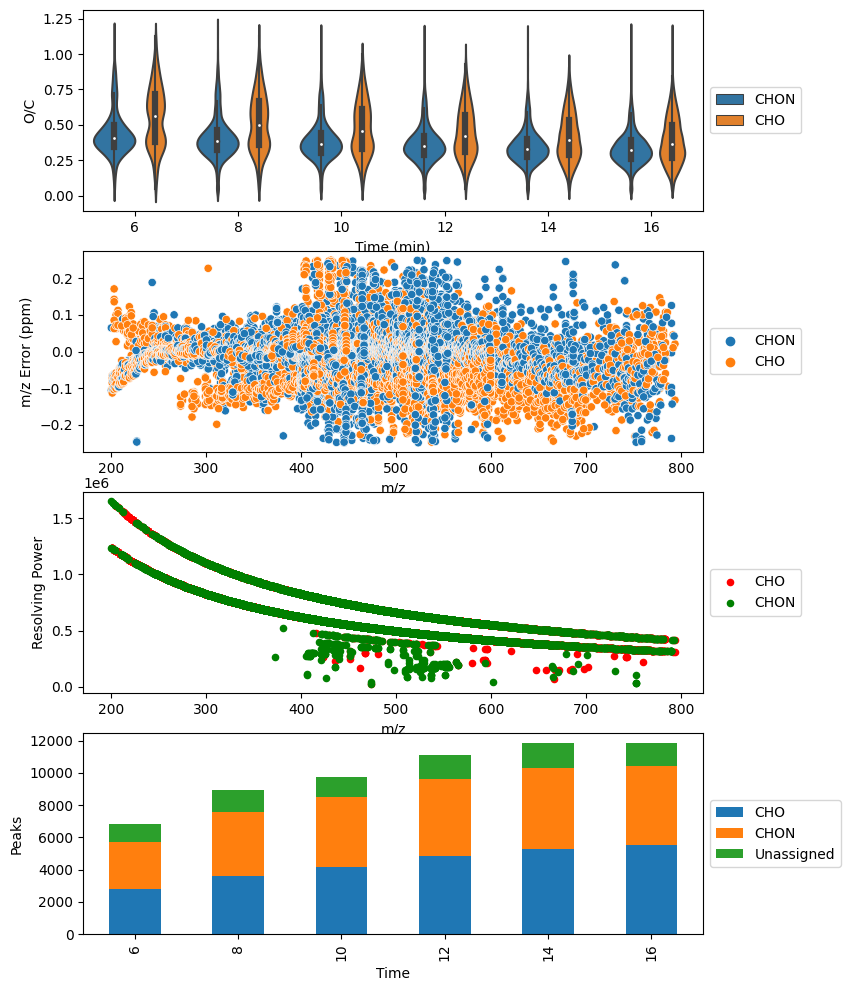

In [257]:
data.assess_all_results() ## why is it necessary to run this to get self.complete_results_df?

In [262]:
# add 'm/z window' and 'rep' columns

data_df = data.complete_results_df

data_df = add_mzwindow_col(data_df)

data_df = addRepCol(data_df)

print(data_df['m/z window'].unique())
print(data_df['Rep'].unique())
print(data_df['file'].unique())

20221103_LBA_Boiteau_Zorbax3p5_spring_400_600.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_400_500.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_500_600.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_600.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz.raw
[1]
['400-600 m/z' '200-1200 m/z' '400-500 m/z' '500-600 m/z']
[1]
['20221103_LBA_Boiteau_Zorbax3p5_spring_400_600.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_spring_400_500.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_spring_500_600.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_600.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz.raw']


In [170]:
# save assignment results as pd dataframe and export as .csv 
data_df.to_csv("/Users/christiandewey/Library/CloudStorage/Box-Box/data/assignments/spring/spring-max600mz_22-12_6_Cu.csv")


In [263]:
#create subsets of assignments based m/z window

list100mz = []
list200mz = []
listfullzmz = [] 

for mzwindow in data_df['m/z window'].unique():

    r_df = data_df[data_df['m/z window'] == mzwindow]

    if (mzwindow == '400-600 m/z') or (mzwindow == '600-800 m/z'):
        list200mz.append(r_df)

    elif (mzwindow == '400-500 m/z') or (mzwindow == '500-600 m/z') or (mzwindow == '600-700 m/z') or (mzwindow == '700-800 m/z'):
        list100mz.append(r_df) 

    elif (mzwindow == '200-1200 m/z'):
        listfullzmz.append(r_df) 

mz100 = pd.concat(list100mz)
mz200 = pd.concat(list200mz)
mzfull = pd.concat(listfullzmz)


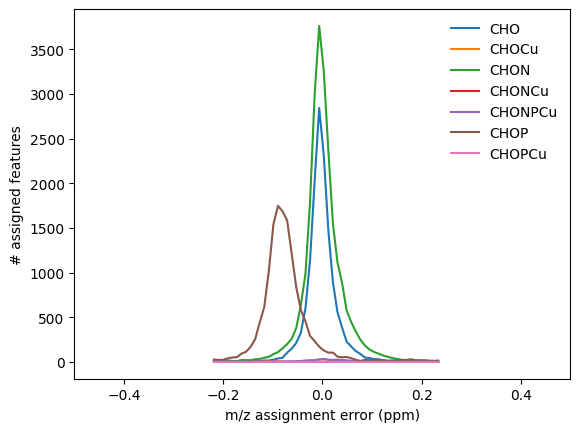

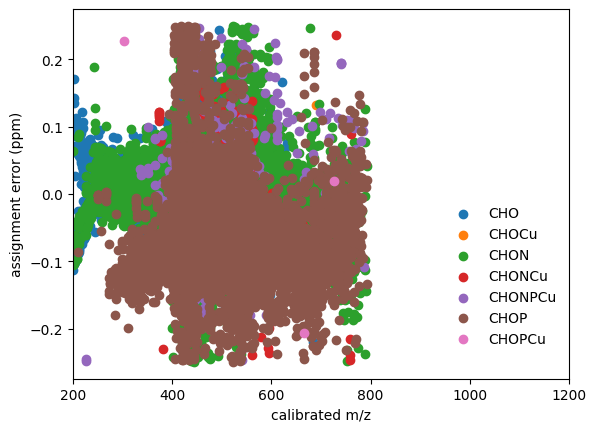

In [264]:
# plot assignment error distribution for full data set
pltMZerror(assignMolClass(data_df))

plt.show()

pltMZerror_pts(assignMolClass(data_df))

plt.show()

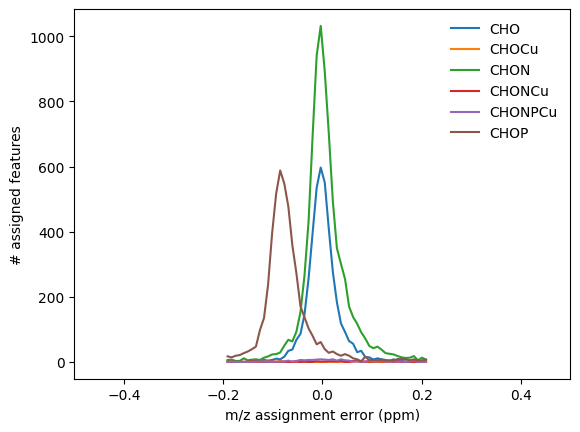

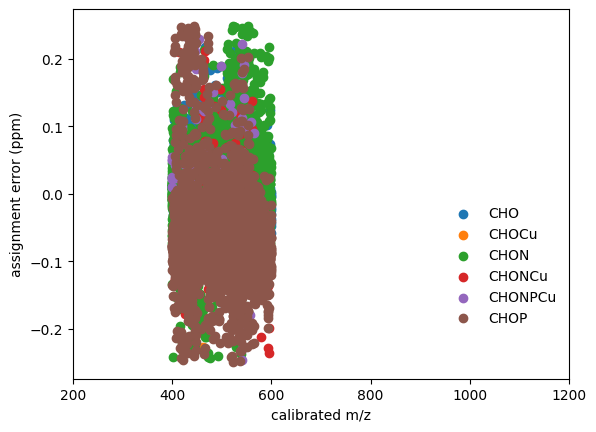

In [265]:
# plot assignment error dist for m/z 100 scans
pltMZerror(assignMolClass(mz100))

plt.show()

pltMZerror_pts(assignMolClass(mz100))

plt.show()

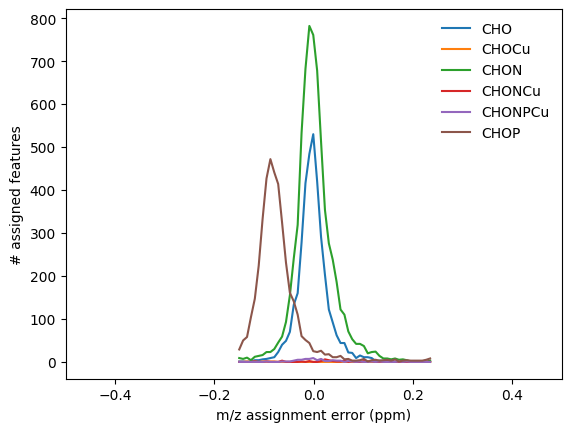

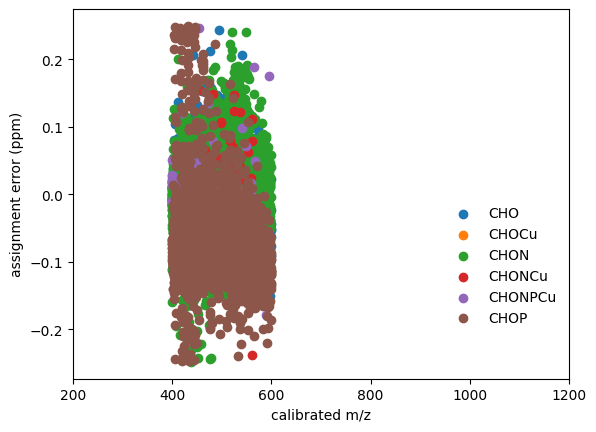

In [266]:
# plot assignment error dist for m/z 200 scans
pltMZerror(assignMolClass(mz200))

plt.show()

pltMZerror_pts(assignMolClass(mz200))

plt.show()

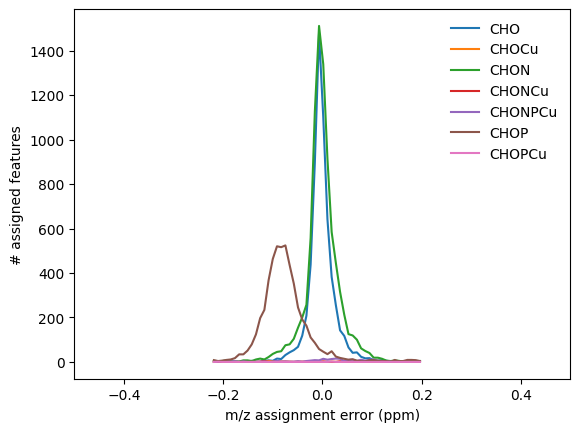

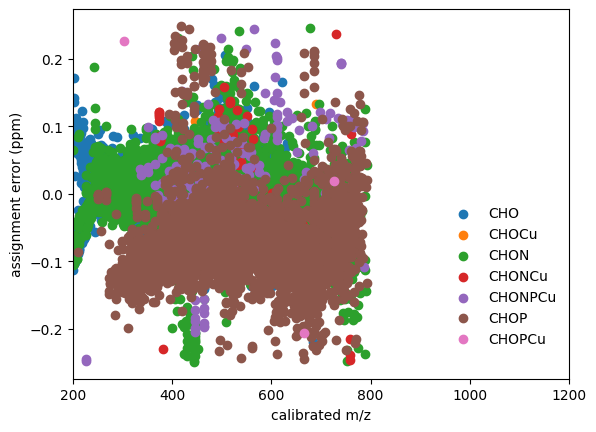

In [267]:
# plot assignment error dist for full m/z scans 
pltMZerror(assignMolClass(mzfull))

plt.show()

pltMZerror_pts(assignMolClass(mzfull))

plt.show()

In [268]:
assigned_100mz = mz100[~mz100['Molecular Formula'].isnull()]
assigned_200mz = mz200[~mz200['Molecular Formula'].isnull()]
assigned_fullmz = mzfull[~mzfull['Molecular Formula'].isnull()]

print('400-600 m/z, 100 m/z windowing: \n%s features total; %s assigned (%.1f%%)' %(np.shape(mz100)[0],  np.shape(assigned_100mz)[0], np.shape(assigned_100mz)[0] / np.shape(mz100)[0] * 100))
print('400-600 m/z, 200 m/z windowing: \n%s features total; %s assigned (%.1f%%)' %(np.shape(mz200)[0], np.shape(assigned_200mz)[0], np.shape(assigned_200mz)[0] / np.shape(mz200)[0] * 100))
print('200-800 m/z window (full scan): \n%s features total; %s assigned (%.1f%%)' %(np.shape(mzfull)[0],np.shape(assigned_fullmz)[0],  np.shape(assigned_fullmz)[0] / np.shape(mzfull)[0] * 100))

print('\n\n')

unique_100mz = getUniqueFeatures(assigned_100mz)
unique_200mz = getUniqueFeatures(assigned_200mz)
unique_fullmz = getUniqueFeatures(assigned_fullmz)


400-600 m/z, 100 m/z windowing: 
24110 features total; 19161 assigned (79.5%)
400-600 m/z, 200 m/z windowing: 
18807 features total; 16279 assigned (86.6%)
200-800 m/z window (full scan): 
27760 features total; 23260 assigned (83.8%)



total # results: 19161
# unique results: 19058
total # results: 16279
# unique results: 16279
total # results: 23260
# unique results: 22667


In [269]:
assigned_100mz_456 = assigned_100mz[(assigned_100mz['m/z']>=400)]
assigned_100mz_456 = assigned_100mz_456[(assigned_100mz_456['m/z']<=600)]

assigned_200mz_456 = assigned_200mz[(assigned_200mz['m/z']>=400)]
assigned_200mz_456 = assigned_200mz_456[(assigned_200mz_456['m/z']<=600)]

assigned_fullmz_456 = assigned_fullmz[(assigned_fullmz['m/z']>=400)]
assigned_fullmz_456 = assigned_fullmz_456[(assigned_fullmz_456['m/z']<=600)]

mz100_456 = mz100[(mz100['m/z']>=400)]
mz100_456 = mz100_456[(mz100_456['m/z']<=600)]

mz200_456 = mz200[(mz200['m/z']>=400)]
mz200_456 = mz200_456[(mz200_456['m/z']<=600)]

mzfull_456 = mzfull[(mzfull['m/z']>=400)]
mzfull_456 = mzfull_456[(mzfull_456['m/z']<=600)]

print('400-600 m/z, 100 m/z windowing: \n%s features total\n%s assigned (%.1f%%)' %(np.shape(mz100_456)[0],  np.shape(assigned_100mz_456)[0], np.shape(assigned_100mz_456)[0] / np.shape(mz100_456)[0] * 100))
print('\n400-600 m/z, 200 m/z windowing: \n%s features total\n%s assigned (%.1f%%)' %(np.shape(mz200_456)[0], np.shape(assigned_200mz_456)[0], np.shape(assigned_200mz_456)[0] / np.shape(mz200_456)[0] * 100))
print('\n400-600 m/z, full window: \n%s features total\n%s assigned (%.1f%%)' %(np.shape(mzfull_456)[0],np.shape(assigned_fullmz_456)[0],  np.shape(assigned_fullmz_456)[0] / np.shape(mzfull_456)[0] * 100))



400-600 m/z, 100 m/z windowing: 
24110 features total
19161 assigned (79.5%)

400-600 m/z, 200 m/z windowing: 
18807 features total
16279 assigned (86.6%)

400-600 m/z, full window: 
13918 features total
11954 assigned (85.9%)


In [270]:

unique_100mz_456 = getUniqueFeatures(assigned_100mz_456)
unique_200mz_456 = getUniqueFeatures(assigned_200mz_456)
unique_fullmz_456 = getUniqueFeatures(assigned_fullmz_456)

total # results: 19161
# unique results: 19058
total # results: 16279
# unique results: 16279
total # results: 11954
# unique results: 11886


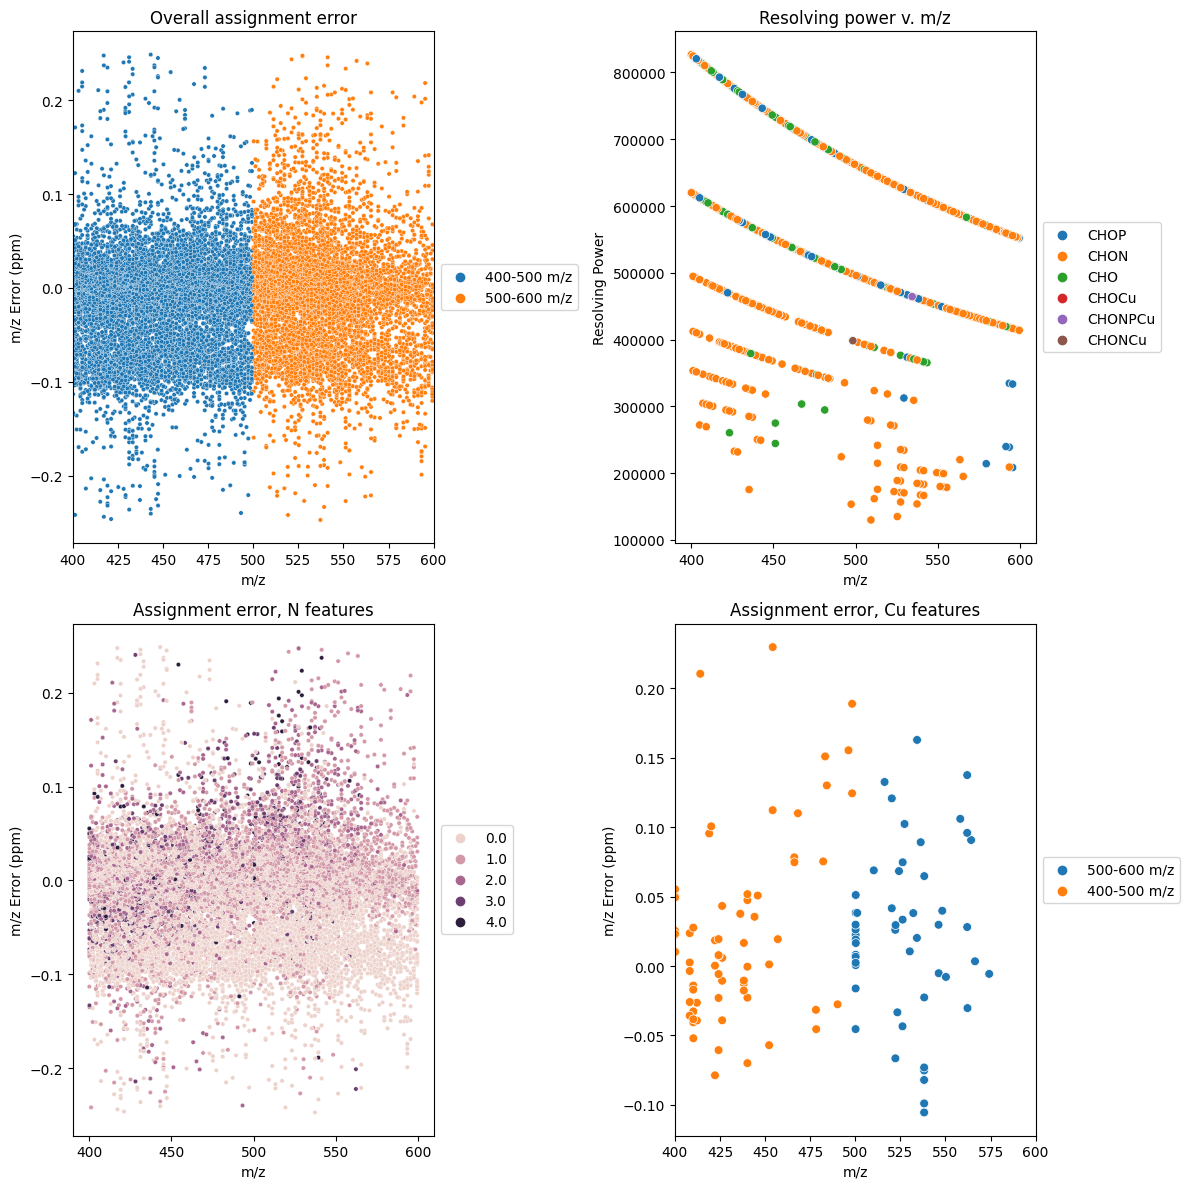

['20221103_LBA_Boiteau_Zorbax3p5_spring_400_500.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_spring_500_600.raw']


In [271]:
# 100 m/z window, error plots with blanks removed 
mask = ~unique_100mz_456['file'].str.contains('qh2o', case=False, na=False)
unique_100mz_nb=unique_100mz_456[mask]
df = assignMolClass(unique_100mz_nb)

fig = plotUnique(df,ps=10)
plt.tight_layout()
plt.show()
print(unique_100mz_nb['file'].unique())

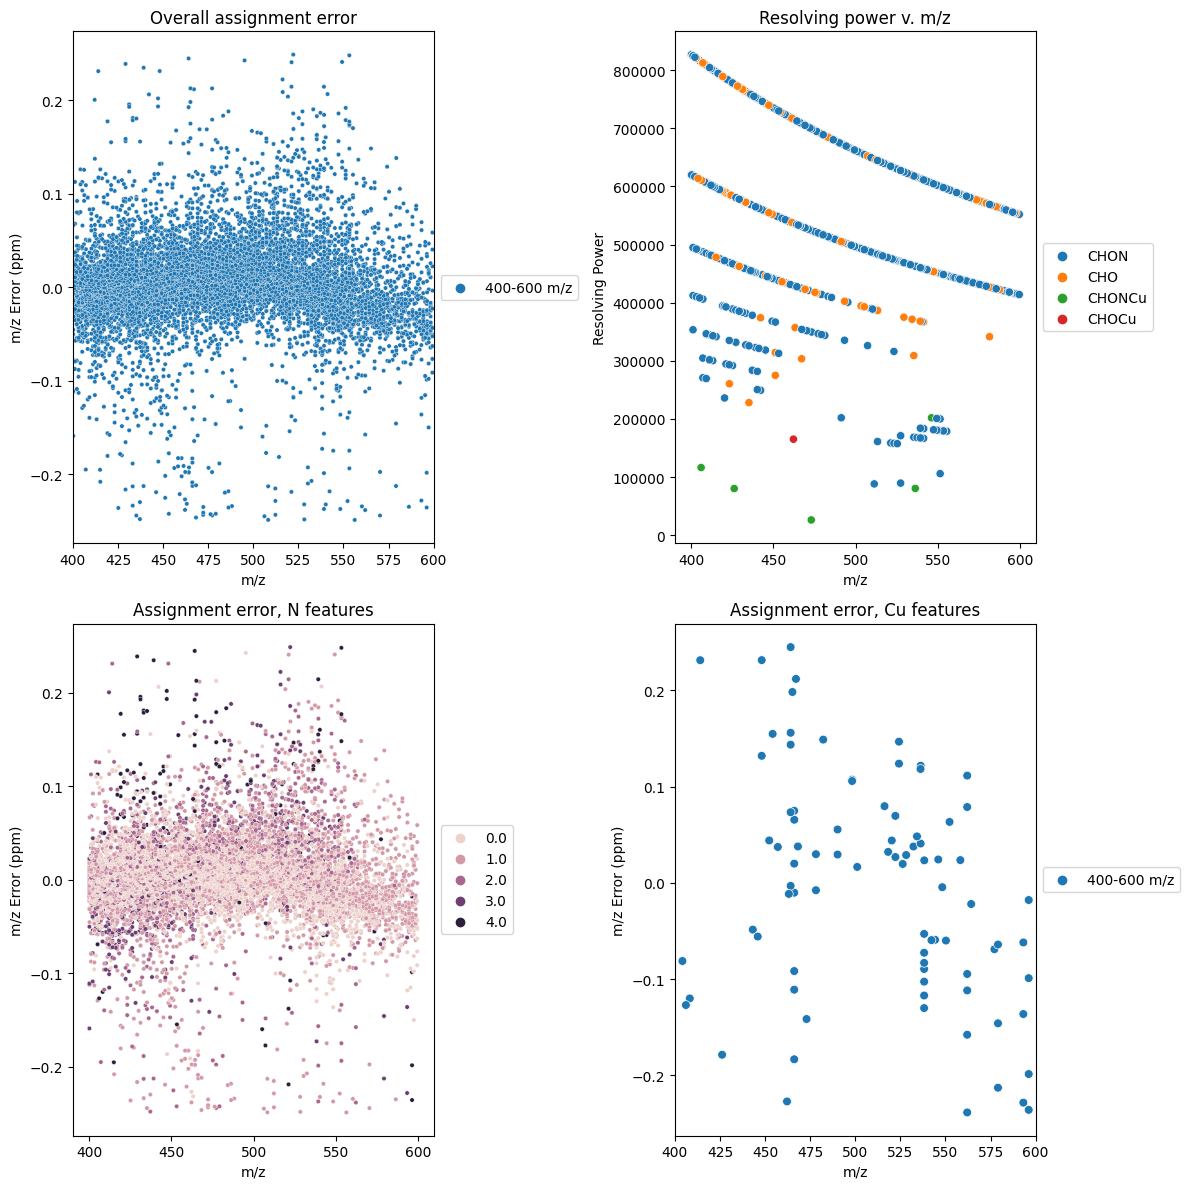

['20221103_LBA_Boiteau_Zorbax3p5_spring_400_600.raw' 'mz200_400_600_blnk']


In [234]:
# 200 m/z window, error plots with blanks removed 

mask = ~unique_200mz_456['file'].str.contains('qh2o', case=False, na=False)
unique_200mz_nb=unique_200mz_456[mask]


fig = plotUnique(assignMolClass(unique_200mz_nb),ps=10)
plt.tight_layout()
plt.show()
plt.close('all')

print(unique_200mz_nb['file'].unique())

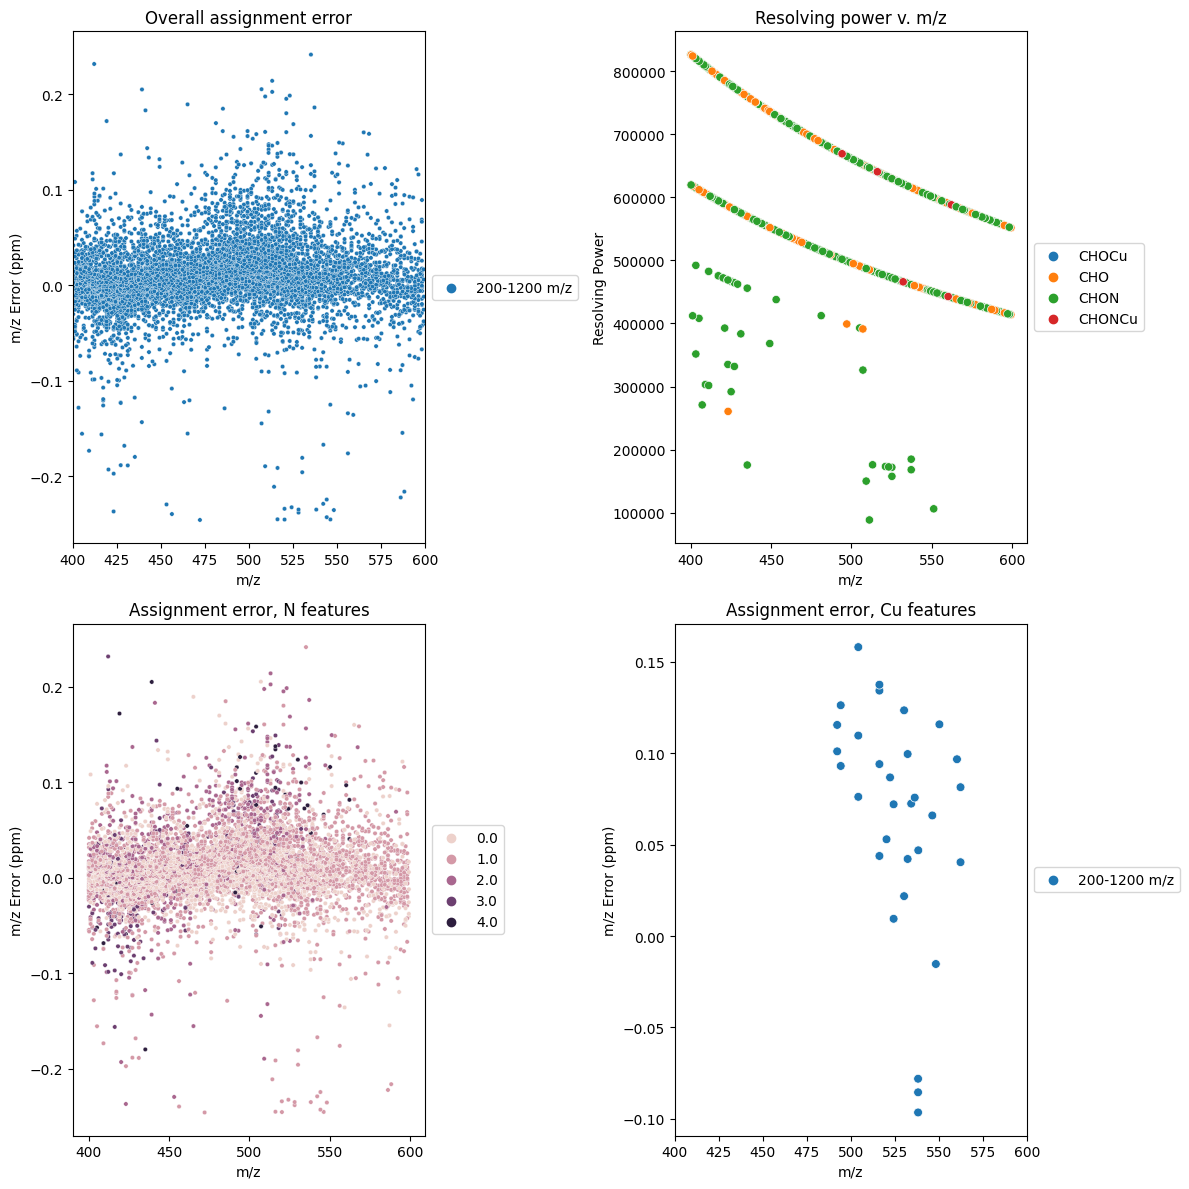

['20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz.raw']


In [235]:
# full m/z window, error plots with blanks removed 

mask = ~unique_fullmz_456['file'].str.contains('qh2o', case=False, na=False)
unique_fullmz_nb=unique_fullmz_456[mask]


fig = plotUnique(assignMolClass(unique_fullmz_nb),ps=10)
plt.tight_layout()
plt.show()
plt.close('all')

print(unique_fullmz_nb['file'].unique())

In [236]:
# create 200 m/z blank files from 100 m/z blank files (did not collect 200 m/z blank files)

blank_files = [f for f in data._raw_filelist if 'qh2o' in f]

blank_data = []

for f in blank_files:

    if 'fullmz' not in f:
        
        temp = data_df[data_df['file'] == f] 

        blank_data.append(temp)

blanks_df = pd.concat(blank_data)

rep1_temp = blanks_df[~blanks_df['file'].str.contains('rep2')]
rep1_temp = rep1_temp[rep1_temp['m/z'] <= 600]
rep1_temp['file'] = 'mz200_400_600_blnk'
rep1_temp['m/z window'] = '400-600 m/z'

blanks_df = pd.concat([blanks_df,rep1_temp])

#rep1_temp = blanks_df[~blanks_df['file'].str.contains('rep2')]
#rep1_temp = rep1_temp[rep1_temp['m/z'] >= 600]
#rep1_temp['file'] = 'mz200_600_800_blnk'
#rep1_temp['m/z window'] = '600-800 m/z'

blanks_df = pd.concat([blanks_df,rep1_temp])


rep2_temp = blanks_df[blanks_df['file'].str.contains('rep2')]
rep2_temp = rep2_temp[rep2_temp['m/z'] <= 600]
rep2_temp['file'] = 'mz200_400_600_blnk_rep2'
rep2_temp['m/z window'] = '400-600 m/z'

blanks_df = pd.concat([blanks_df,rep2_temp])

#rep2_temp = blanks_df[~blanks_df['file'].str.contains('rep2')]
#rep2_temp = rep2_temp[rep2_temp['m/z'] >= 600]
#rep2_temp['file'] = 'mz200_600_800_blnk_rep2'
#rep2_temp['m/z window'] = '600-800 m/z'

blanks_df = pd.concat([blanks_df,rep2_temp])

print(blanks_df['file'].unique())

print(blanks_df['m/z window'].unique())



['20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_600.raw' 'mz200_400_600_blnk']
['400-500 m/z' '500-600 m/z' '400-600 m/z']


In [237]:
# add 200 m/z blank data to master df

mz200_blanks = blanks_df[blanks_df['m/z window'] == '400-600 m/z']
data_df = pd.concat([data_df, mz200_blanks])

for f in data_df['file'].unique():
    print(f)




20221103_LBA_Boiteau_Zorbax3p5_spring_400_600.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_400_500.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_500_600.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_600.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz.raw
mz200_400_600_blnk


In [238]:
# add fullmz blanks to blanks df
blanks_df = pd.concat([blanks_df, data_df[data_df['file'] =='20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz_rep2.raw' ]])
blanks_df = pd.concat([blanks_df, data_df[data_df['file'] =='20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz.raw' ]])

print(blanks_df['m/z window'].unique())

['400-500 m/z' '500-600 m/z' '400-600 m/z' '200-1200 m/z']


In [239]:
# add column with blank file identity to use in blank subtraction
df_backup = data_df
df_backup.to_csv("/Users/christiandewey/Library/CloudStorage/Box-Box/data/assignments/spring/spring-max600mz_backup.csv")

data_df['blank file'] = data_df.index

for window in data_df['m/z window'].unique():

    temp1 = data_df[data_df['m/z window'] == window] # all features collected in given m/z window       
    btemp1 = blanks_df[blanks_df['m/z window'] == window] # all blank feautres collected in same m/z window

    for r in temp1['Rep'].unique():
        temp2 = temp1[temp1['Rep'] == r]
        btemp2 = btemp1[btemp1['Rep'] == r]


        temp2['blank file'] = btemp2['file'].iloc[0]

        data_df[(data_df['m/z window'] == window) & (data_df['Rep'] == r)]  = temp2


print(data_df['blank file'].unique())

['mz200_400_600_blnk' '20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_600.raw']


In [240]:
def blankSubtract(df, blnkthresh = 0.9):
    
    holder = []
    for file in df['file'].unique():
        
        #if file == 
        sub = df[df['file'] == file]

        blkf = sub['blank file'].iloc[0]


        sub[sub[file]== np.nan] = 0

        nom = sub[file]
        den = sub[blkf]

        nom = nom.replace(np.nan,0)
        den = den.replace(np.nan,1)

        if file != blkf:
            nom = nom
        elif file == blkf:
            nom = nom * (blnkthresh*0.8)

        sub['blank subtract'] = nom/den
        holder.append(sub)
    df_end = pd.concat(holder)
    df_end = df_end[df_end['blank subtract'] > blnkthresh]
    return df_end

In [241]:
df_unique = getUniqueFeatures(data_df)


total # results: 86753
# unique results: 23599


In [242]:
df_bs = blankSubtract(df_unique, blnkthresh=0.3)


(20719, 44)


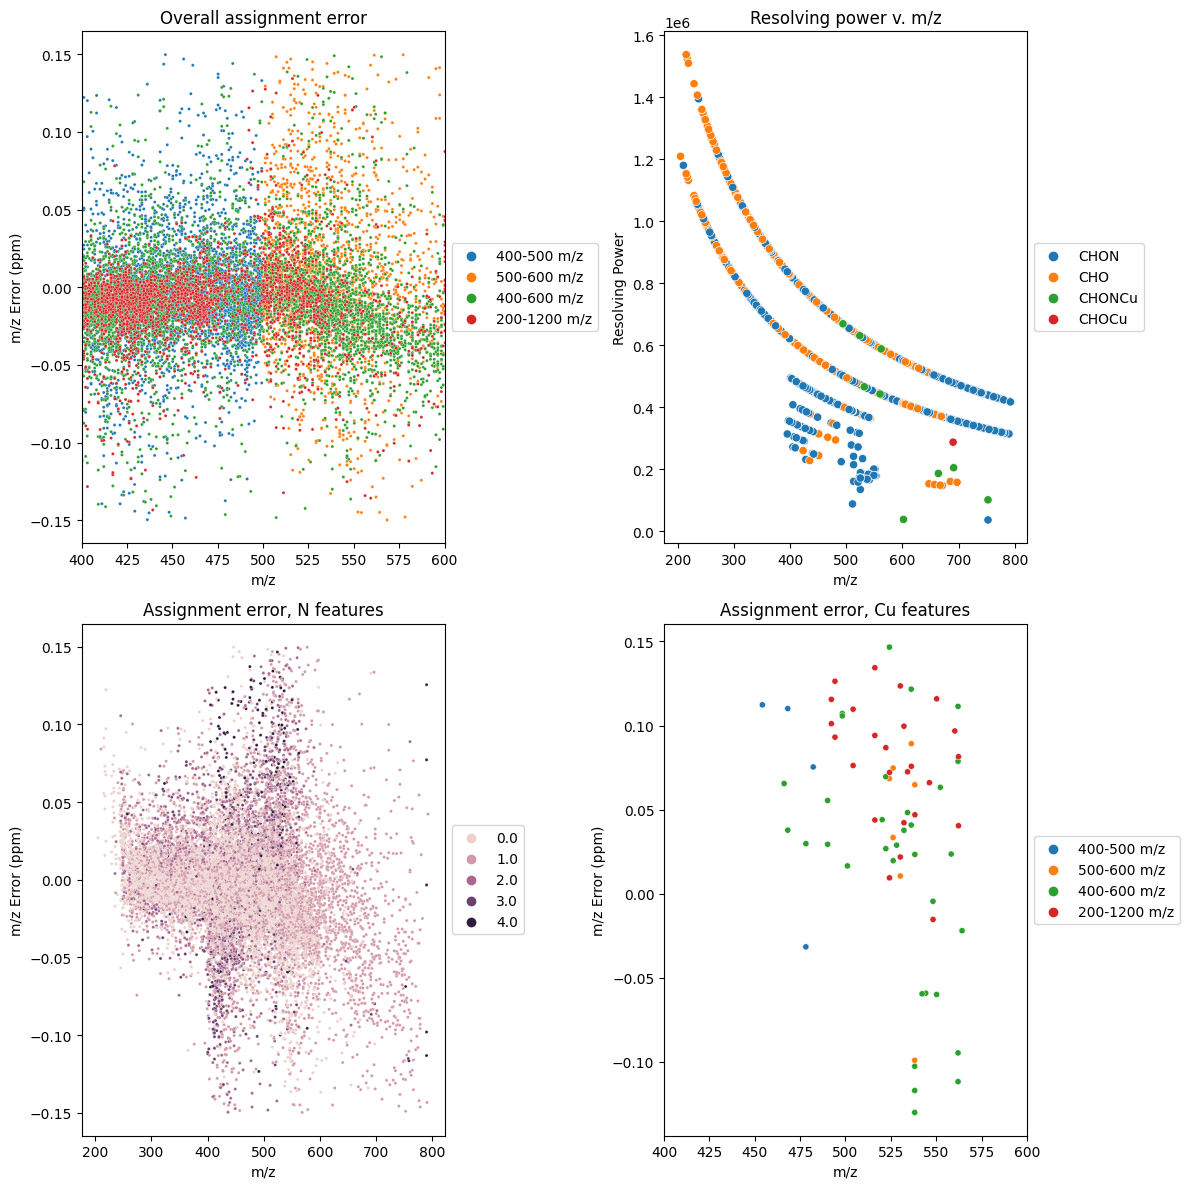

In [243]:
temp = df_bs[abs(df_bs['m/z Error (ppm)'])<0.15]
print(np.shape(temp))
fig = plotUnique(assignMolClass(pd.concat([temp[temp['m/z window']== '400-500 m/z'], temp[temp['m/z window']=='500-600 m/z'], temp[temp['m/z window']=='400-600 m/z'], temp[temp['m/z window']=='200-1200 m/z']])),ps=5)

plt.tight_layout()
plt.show()
plt.close('all')

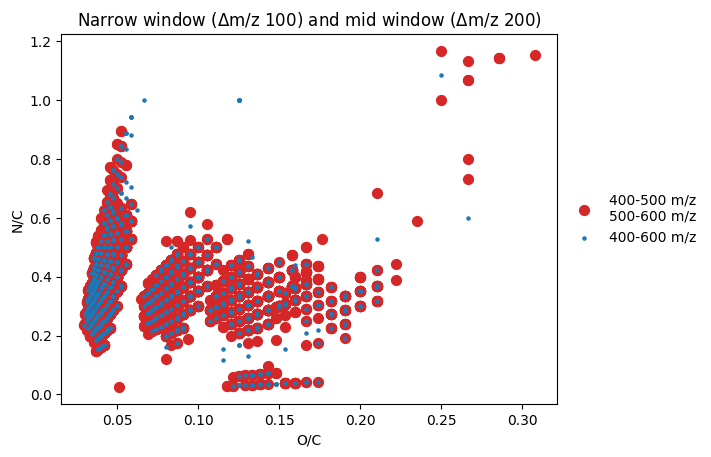

In [244]:
mz100_bs = df_bs[(df_bs['m/z window'] == '400-500 m/z') | (df_bs['m/z window'] == '500-600 m/z')]

mz200_bs = df_bs[(df_bs['m/z window'] == '400-600 m/z')]

mzfull_bs = df_bs[(df_bs['m/z window'] == '200-1200 m/z')]
mzfull_bs = mzfull_bs[(mzfull_bs['m/z']>=400) & (mzfull_bs['m/z']<= 600)]

df = mz100_bs
df2 = mz200_bs
df3 = mzfull_bs
fig, ax = plt.subplots()
ax.scatter(x=df['N/C'],y=df['O/C'],c='C3',s=50,label='400-500 m/z\n500-600 m/z')#,s=df['S/N']
#sns.scatterplot(x='N/C',y='O/C', hue='m/z', data=df, ax=ax,s=50)
ax.scatter(x=df2['N/C'],y=df2['O/C'],c='C0',s=5,label='400-600 m/z') #s=df2['S/N'],
#ax.scatter(x=df3['N/C'],y=df3['O/C'],c='C5',label='200-1200 m/z') #s=df3['S/N']
ax.set(xlabel='O/C',ylabel='N/C')
#ax.set_xlim(0,1.2)
#ax.set_ylim(0,0.5)
ax.legend(frameon=False, bbox_to_anchor=(1.0,0.5), loc='center left')
plt.title(r'Narrow window ($\Delta$m/z 100) and mid window ($\Delta$m/z 200)')
plt.show()


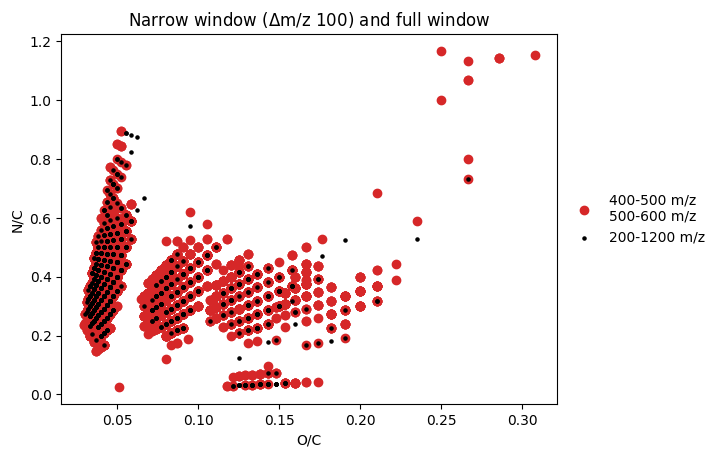

In [245]:
mz100_bs = df_bs[(df_bs['m/z window'] == '400-500 m/z') | (df_bs['m/z window'] == '500-600 m/z')]

mz200_bs = df_bs[(df_bs['m/z window'] == '400-600 m/z')]

mzfull_bs = df_bs[(df_bs['m/z window'] == '200-1200 m/z')]
mzfull_bs = mzfull_bs[(mzfull_bs['m/z']>=400) & (mzfull_bs['m/z']<= 600)]

df = mz100_bs
df2 = mz200_bs
df3 = mzfull_bs
fig, ax = plt.subplots()
ax.scatter(x=df['N/C'],y=df['O/C'],c='C3',label='400-500 m/z\n500-600 m/z')#,s=df['S/N']
#ax.scatter(x=df2['N/C'],y=df2['O/C'],c='black',s=5,label='400-600 m/z') #s=df2['S/N'],
ax.scatter(x=df3['N/C'],y=df3['O/C'],c='black',s=5,label='200-1200 m/z') #s=df3['S/N']
ax.set(xlabel='O/C',ylabel='N/C')
#ax.set_xlim(0,1.2)
#ax.set_ylim(0,0.5)
ax.legend(frameon=False, bbox_to_anchor=(1.0,0.5), loc='center left')
plt.title(r'Narrow window ($\Delta$m/z 100) and full window')
plt.show()


In [246]:
temp = df_bs[df_bs['m/z'] >= 400]
temp = temp[temp['m/z']<=600]

temp['m/z Window Size'] = temp.Index

for i in range(len(temp['m/z window'])):

    w = temp['m/z window'].iloc[i]

    if (w == '400-500 m/z') or (w == '500-600 m/z'):
        
        temp['m/z Window Size'].iloc[i] = '100 m/z'

    elif (w == '400-600 m/z'):
        
        temp['m/z Window Size'].iloc[i] = '200 m/z'

    elif (w == '200-1200 m/z'):
        
        temp['m/z Window Size'].iloc[i] = '1000 m/z'

In [247]:
mz100_contains_cu = mz100_bs[(mz100_bs['Cu'] == 1) | (mz100_bs['65Cu'] ==1) ]
print(np.shape(mz100_contains_cu))
mz100_cu_limited_err = mz100_contains_cu[abs(mz100_contains_cu['m/z Error (ppm)']) < 0.2]
print(np.shape(mz100_cu_limited_err))

mz200_contains_cu = mz200_bs[(mz200_bs['Cu'] == 1) ]
print(np.shape(mz200_contains_cu))
mz200_cu_limited_err = mz200_contains_cu[abs(mz200_contains_cu['m/z Error (ppm)']) < 0.2]
print(np.shape(mz200_cu_limited_err))

mzfull_contains_cu = mzfull_bs[(mzfull_bs['Cu'] == 1)]
print(np.shape(mzfull_contains_cu))
mzfull_cu_limited_err = mzfull_contains_cu[abs(mzfull_contains_cu['m/z Error (ppm)']) < 0.2]
print(np.shape(mzfull_cu_limited_err))


(56, 44)
(55, 44)
(86, 44)
(83, 44)
(45, 44)
(44, 44)


In [273]:
for i in range(len(mz100_contains_cu.index)):

    if mz100_contains_cu['m/z Error (ppm)'].iloc[i] < 0.05:

        print(mz100_contains_cu['m/z Error (ppm)'].iloc[i])

        print(mz100_contains_cu['Molecular Formula'].iloc[i])
        print(mz100_contains_cu['Time'].iloc[i])
        print(mz100_contains_cu['m/z'].iloc[i])
        print('\n')



-0.16916370629306984
C26 H34 O8 Cu1
4
538.1620308703544


0.03660270699472515
C28 H34 O2 N4 Cu1
6
522.205004278799


0.04200686107827718
C29 H34 O2 N4 Cu1
6
534.2050105888036


-0.05952085684887628
C29 H32 O1 N4 Cu1
8
516.194443745053


0.01055410922298078
C30 H34 O1 N4 Cu1
8
530.2101356580407


-0.025929661371432686
C30 H32 O1 N4 Cu1
10
528.1944993280586


0.018796459477549658
C31 H34 O1 N4 Cu1
10
542.2101816274356


0.033433271082438994
C28 H38 O2 N4 Cu1
10
526.2363942626067


0.03794703243585138
C31 H40 O2 N4 Cu1
10
564.252070738014


-0.09899476790578352
C26 H34 O8 Cu1
12
538.1622572614142


-0.020064012605993036
C32 H40 O2 N4 Cu1
12
576.2520872449071


0.02648768895766677
C30 H42 O2 N4 Cu1
12
554.2677463994992


0.04461900842314454
C33 H40 O1 N4 Cu1
12
572.2572066105378


0.007423920628938219
C34 H42 O1 N4 Cu1
14
586.2729077938118


-0.03984769622627546
C29 H42 O1 N4 65Cu1
16
528.2710280467597


0.006740889085527687
C30 H42 O2 N4 Cu1
16
554.2678059181294


0.027862824910229365
C33

In [193]:
temp = temp[temp['Cu'] == 1]

temp['overlap'] = temp.Index

for i in range(len(temp['Molecular Formula'])):

    mf = temp['Molecular Formula'].iloc[i]

    if (mf not in mzfull_contains_cu['Molecular Formula'].values) and (mf not in mz200_contains_cu['Molecular Formula'].values):
        temp['overlap'].iloc[i] = 'n'

    elif (mf in mzfull_contains_cu['Molecular Formula'].values) and (mf not in mz200_contains_cu['Molecular Formula'].values):
        
        temp['overlap'].iloc[i] = 'nw'

    elif (mf not in mzfull_contains_cu['Molecular Formula'].values) and (mf in mz200_contains_cu['Molecular Formula'].values):
        
        temp['overlap'].iloc[i] = 'nm'

    elif (mf in mzfull_contains_cu['Molecular Formula'].values) and (mf in mz200_contains_cu['Molecular Formula'].values):
        
        temp['overlap'].iloc[i] = 'nmw'



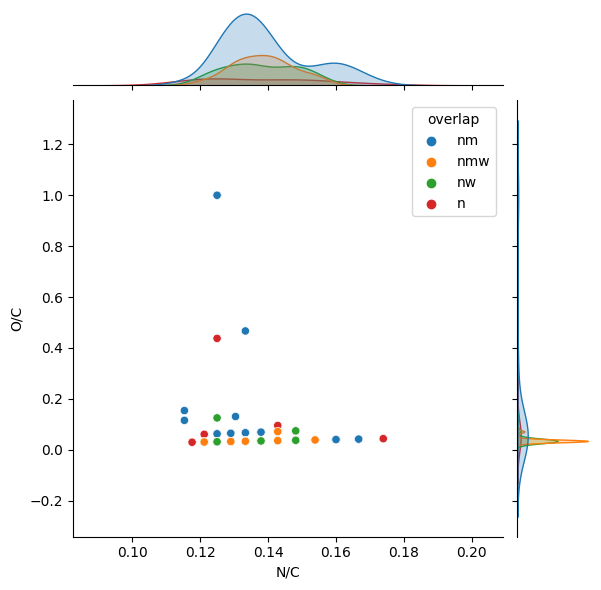

In [194]:
sns.jointplot(data=temp, x='N/C',y='O/C', hue='overlap')

In [195]:
print(np.shape(mzfull_cu_limited_err))
print(np.shape(mz100_cu_limited_err))

combo = pd.concat([mz100_cu_limited_err, mzfull_cu_limited_err])

combo['m/z Window Size'] = combo.Index

for i in range(len(combo['m/z window'])):

    w = combo['m/z window'].iloc[i]

    if (w == '400-500 m/z') or (w == '500-600 m/z'):
        
        combo['m/z Window Size'].iloc[i] = '100 m/z'

    elif (w == '400-600 m/z'):
        
        combo['m/z Window Size'].iloc[i] = '200 m/z'

    elif (w == '200-1200 m/z'):
        
        combo['m/z Window Size'].iloc[i] = '1000 m/z'

combo['m/z Window Size'].unique()

(44, 44)
(54, 44)


array(['100 m/z', '1000 m/z'], dtype=object)

In [196]:
mz100_cu_limited_err.columns

Index(['Index', 'm/z', 'Calibrated m/z', 'Calculated m/z', 'Peak Height',
       'Peak Area', 'Resolving Power', 'S/N', 'Ion Charge', 'm/z Error (ppm)',
       'm/z Error Score', 'Isotopologue Similarity', 'Confidence Score', 'DBE',
       'H/C', 'O/C', 'Heteroatom Class', 'Ion Type', 'Is Isotopologue',
       'Mono Isotopic Index', 'Molecular Formula', 'C', 'H', 'O', 'N', '13C',
       'Cu', 'Time', '18O', 'file', '65Cu', 'm/z window', 'Rep', 'blank file',
       '20221103_LBA_Boiteau_Zorbax3p5_spring_400_600.raw',
       '20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz.raw',
       '20221103_LBA_Boiteau_Zorbax3p5_spring_400_500.raw',
       '20221103_LBA_Boiteau_Zorbax3p5_spring_500_600.raw',
       '20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500.raw',
       '20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_600.raw',
       '20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz.raw', 'mz200_400_600_blnk',
       'N/C', 'blank subtract'],
      dtype='object')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


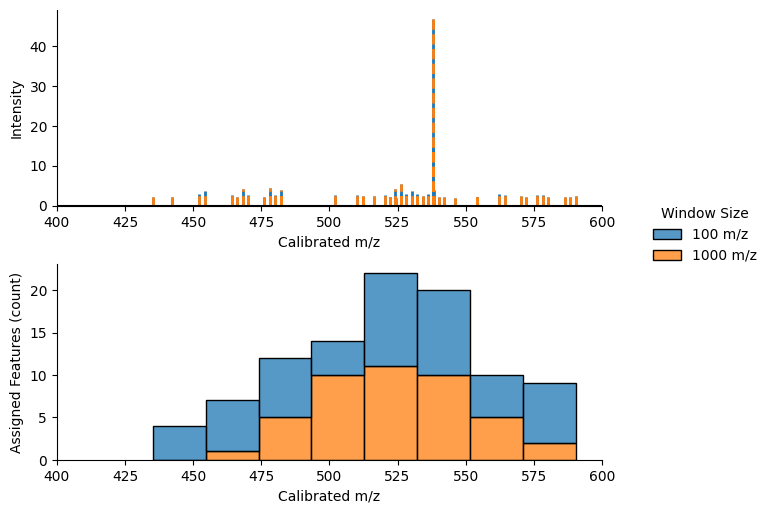

In [210]:
import matplotlib.gridspec as gridspec

#fig, (ax1_t,ax1_b, ax2) = plt.subplots(nrows=3, ncols=1, sharex = True, gridspec_kw={'hspace':0.02})
plt.subplots_adjust(hspace=0.02)
#make outer gridspec
outer = gridspec.GridSpec(2, 1, height_ratios = [1, 1]) 
#make nested gridspecs
gs2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[1])
gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[0], hspace = .05)

d1=normMS(mz100_cu_limited_err,mz100_cu_limited_err)
d2=normMS(mzfull_cu_limited_err,mzfull_cu_limited_err)

ax1_b = plt.subplot(gs1[0])
ax1_b = plot_ms(df1=d1,  df2=d1, start_mz=400, end_mz=600,ax_ms=ax1_b, norm=False)

sns.despine(ax=ax1_b)

ax1_b.set_ylim(bottom=0)





ax2 = plt.subplot(gs2[0])

sns.despine(ax=ax2)

sns.histplot(combo, x="Calibrated m/z", hue="m/z Window Size", multiple="stack", ax=ax2)
ax2.set_ylabel('Assigned Features (count)')
ax2.set_xlim(400,600)
legend = ax2.get_legend()
handles = legend.legendHandles
labels = ['100 m/z','1000 m/z']
ax2.legend_.remove()

fig = plt.gcf()

fig.legend(handles, labels, bbox_to_anchor=(1.02, 0.5), loc='center left',frameon=False, borderaxespad=0, title = 'Window Size')

plt.show()

In [ ]:
inds = np.where(np.asarray(mz100_EICdic[mf].time)<28)

np.asarray(mz100_EICdic[mf].time)[inds]

In [ ]:
#data.master_data_holder['20221103_LBA_Boiteau_Zorbax3p5_spring_400_500_rep2.raw'] #[file]={'parser': parser}
mz100_cu_limited_err = mz100_contains_cu[abs(mz100_contains_cu['m/z Error (ppm)']) < 0.25]
mz100_EICdic = {}
for mz,file,mf in zip(mz100_cu_limited_err['m/z'],mz100_cu_limited_err['file'],mz100_cu_limited_err['Molecular Formula']):
    
    parser = data.master_data_holder[file]['parser']    
 
    EIC=parser.get_eics(target_mzs=[mz],tic_data={},peak_detection=False,smooth=False)
    mz100_EICdic[mf]=EIC[0][mz]
    #mz100_EICdic[mz]={'eic':EIC[0][mz],'formula':mf}


In [ ]:
mzfull_cu_limited_err = mzfull_contains_cu[abs(mzfull_contains_cu['m/z Error (ppm)']) < 0.25]
fullmz_EICdic = {}
for mz,file,mf in zip(mzfull_cu_limited_err['m/z'],mzfull_cu_limited_err['file'],mzfull_cu_limited_err['Molecular Formula']):
    
    parser = data.master_data_holder[file]['parser']
 
    EIC=parser.get_eics(target_mzs=[mz],tic_data={},peak_detection=False,smooth=False)
    fullmz_EICdic[mf]=EIC[0][mz]

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

icpms_file = '/Users/christiandewey/Library/CloudStorage/Box-Box/Boiteau Lab/Mass Spec Data/Keck iCAP Q/2022/2022-09/Tillamook, Sept 2022/spring_ENV.csv'
icpms = pd.read_csv(icpms_file, sep=';',header=1)


metals = ['63Cu', '115In']

pdf = PdfPages('/Users/christiandewey/Library/CloudStorage/Box-Box/data/assignments/spring/eics_cu_100mz_fullmz-dec1.pdf')

fig, ax = plt.subplots()

maxicp = 0 
for me in metals:
    me_key = 'Time %s' %me
    ax.plot(icpms[me_key]/60, icpms[me], label=me)        
    



#ax.set_ylim(0,maxicp*1.1)
ax.set_title('Cu ICPMS Trace')
ax.set_xlabel('Time (min)')
ax.set_ylabel('ICPMS signal (cps)')
ax.legend(bbox_to_anchor=(1.05,0.5),loc='center left',frameon =False)
ax.set_xlim(2,30)
fig.tight_layout()
pdf.savefig()

for mf in mz100_EICdic:   

    fig, ax = plt.subplots()
    
    eict=mz100_EICdic[mf].time
    eics=mz100_EICdic[mf].eic

    inds = np.where(np.asarray(eict)<28)

    eict = np.asarray(eict)[inds]
    eics = np.asarray(eics)[inds]

    ax.plot(eict, eics,color = 'red', label=r'$\Delta$m/z 100 window')

    if mf in fullmz_EICdic:
        eic2t = fullmz_EICdic[mf].time
        eic2s = fullmz_EICdic[mf].eic

        eic2t = np.asarray(eic2t)[inds]
        eic2s = np.asarray(eic2s)[inds]
        ax.plot(eic2t,eic2s, color ='C0', label = 'full window')
    ax.set_xlim(4,28)
    ax.set_title(mf)
    ax.legend(frameon = False,bbox_to_anchor=(1.05,0.5),loc='center left')
    fig.tight_layout()
    pdf.savefig()

for mf in fullmz_EICdic:   

    if mf not in mz100_EICdic:

        fig, ax = plt.subplots()

        eic2t = fullmz_EICdic[mf].time
        eic2s = fullmz_EICdic[mf].eic

        inds = np.where(np.asarray(eic2t)<28)

        eic2t = np.asarray(eic2t)[inds]
        eic2s = np.asarray(eic2s)[inds]
        ax.plot(eic2t,eic2s, color ='C5', label = 'full window')

        ax.set_xlim(4,28)
        ax.set_title(mf)
        ax.legend(frameon = False,bbox_to_anchor=(1.05,0.5),loc='center left')
        fig.tight_layout()
        pdf.savefig()

pdf.close()

In [274]:
# C23 H32 O3 Cu

sub = combo[combo['Molecular Formula'] == 'C28 H34 O2 N4 Cu1']

sub

,Index,m/z,Calibrated m/z,Calculated m/z,Peak Height,Peak Area,Resolving Power,S/N,Ion Charge,m/z Error (ppm),...,20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz.raw,20221103_LBA_Boiteau_Zorbax3p5_spring_400_500.raw,20221103_LBA_Boiteau_Zorbax3p5_spring_500_600.raw,20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500.raw,20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_600.raw,20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz.raw,mz200_400_600_blnk,N/C,blank subtract,m/z Window Size
3437,298,522.205004,522.205070,522.205051,1188.807284,-1.242775,475087.126181,2.036132,1,0.036603,...,NaN,NaN,1188.807284,NaN,NaN,NaN,NaN,0.142857,1188.807284,100 m/z
23543,520,522.205245,522.205131,522.205051,1881.794514,-1.868964,633449.565554,2.255239,1,0.153358,...,NaN,NaN,1881.794514,NaN,NaN,NaN,NaN,0.142857,1881.794514,100 m/z


In [ ]:
for i in range(len(mz100_cu_limited_err.index)):

    mf = mz100_cu_limited_err['Molecular Formula'].iloc[i]
    
    if mf in mzfull_cu_limited_err['Molecular Formula'].values:

        print('\n\nNarrow m/z:')
        print(mz100_cu_limited_err.iloc[i,:])

        ind = mzfull_cu_limited_err[mzfull_cu_limited_err['Molecular Formula'] == mf].index 
        print('\nFull m/z:')
        print(mzfull_cu_limited_err.loc[ind].squeeze())




In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

pdf = PdfPages('/Users/christiandewey/Library/CloudStorage/Box-Box/data/assignments/spring/eics_cu_100mz_fullmz-dec5.pdf')


for mf in mz100_EICdic:   

    fig, ax = plt.subplots()
    
    eict=mz100_EICdic[mf].time
    eics=mz100_EICdic[mf].eic

    inds = np.where(np.asarray(eict)<28)

    eict = np.asarray(eict)[inds]
    eics = np.asarray(eics)[inds]

    ax.plot(eict, eics,color = 'red', label=r'$\Delta$m/z 100 window')

    if mf in fullmz_EICdic:
        eic2t = fullmz_EICdic[mf].time
        eic2s = fullmz_EICdic[mf].eic

        eic2t = np.asarray(eic2t)[inds]
        eic2s = np.asarray(eic2s)[inds]
        ax.plot(eic2t,eic2s, color ='C0', label = 'full window')
    ax.set_xlim(4,28)
    ax.set_title(mf)
    ax.legend(frameon = False,bbox_to_anchor=(1.05,0.5),loc='center left')
    fig.tight_layout()
    pdf.savefig()

for mf in fullmz_EICdic:   

    if mf not in mz100_EICdic:

        fig, ax = plt.subplots()

        eic2t = fullmz_EICdic[mf].time
        eic2s = fullmz_EICdic[mf].eic

        inds = np.where(np.asarray(eic2t)<28)

        eic2t = np.asarray(eic2t)[inds]
        eic2s = np.asarray(eic2s)[inds]
        ax.plot(eic2t,eic2s, color ='C5', label = 'full window')

        ax.set_xlim(4,28)
        ax.set_title(mf)
        ax.legend(frameon = False,bbox_to_anchor=(1.05,0.5),loc='center left')
        fig.tight_layout()
        pdf.savefig()

pdf.close()

In [ ]:
refs = pd.read_csv('/Users/christiandewey/CoreMS/tests/tests_data/ftms/nom_pos.ref')
#r45 = refs[(refs['m/z value']>=400) & (refs['m/z value']<=500)]

print(refs[' m/z value'])


In [ ]:

fig, ax2 = plt.subplots()

sns.histplot(refs, x=' m/z value',  ax=ax2)
ax2.set_ylabel('Count')
#ax2.set_xlim(400,600)
#legend = ax2.get_legend()
#handles = legend.legendHandles
#labels = ['100 m/z','1000 m/z']
#ax2.legend_.remove()

fig = plt.gcf()

#fig.legend(handles, labels, bbox_to_anchor=(1.02, 0.5), loc='center left',frameon=False, borderaxespad=0, title = 'Window Size')

plt.show()